<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 8th exercise: <font color="#C70039">Work with a regular Generative Adversarial Network (GAN)</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>

* **Student: Tzu-Lun Yeh**
* **Matriculation Number: 11496498**
* **Date: 12.11.2025**

<img src="https://hubert0527.github.io/COCO-GAN/images/teaser.png" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
The code implements a regular GAN that generates images using a random latent vector as input. While it works great we do not know the mapping of latent vector to the generated image.

Conditional GANs, however, can be used to supply a label during taining so the latent vector can be associated with a specific label - making the generation of images predictable. 

The below coded GAN is using the so-called cifar10 data set, which is standard to many machine learning applications (60,000 32x32 color images in 10 different classes: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).
Following the code trains and generates images based on that cifar10 data set, that is included in the Keras package. 
Further information on the data set can be found here: <a href="https://en.wikipedia.org/wiki/CIFAR-10"> cifar10 data set (wiki)</a>

The code is adapted from the code by Jason Brownlee from his blogs on <a href="https://machinelearningmastery.com/">https://machinelearningmastery.com/</a>.
I seriously urge everyone to follow his blogs and get inspired. Hence, original credit goes to Jason Brownlee. 

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. train the GAN with a higher dimension of the latent space and over more epochs. Are the results improving? 
5. What could be done to further improve the quality of the generated images? 
---------------------------------
### GAN
#### Imports

In [1]:
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

import matplotlib.pyplot as plt
import pandas as pd  # For saving loss history
import os  # For creating model directories

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization  # Enable BN for this experiment
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets.cifar10 import load_data

from tqdm import tqdm  # For progress bars

# this import is needed because there is a problem with the Secure Socket Layer (SSL) certificate, 
# It can be resolved using the below line of code
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

/Users/tly/Documents/GitHub/AML/AML/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Build the GAN architeture

Use the "functional" way of defining the model for the conditional gan but use "sequential" for descriminator and generator as they are straight forward.

#### Define the standalone discriminator model

Given an input image, the Discriminator outputs the likelihood of the image being real.
Binary classification - true or false (1 or 0). So use the sigmoid activation.

In [2]:
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential(name="discriminator")

    # First conv layer
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
    model.add(LeakyReLU(alpha=0.2))

    # Second conv layer - NO BatchNorm (prevents discriminator from overpowering generator)
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten()) #shape of 8192
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) #shape of 1
    
    # Compile model with lower learning rate to prevent D from overpowering G
    opt = Adam(learning_rate=0.0001, beta_1=0.5)  # Reduced from 0.0002 to prevent D from becoming too strong
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

test_discriminator = define_discriminator()
print(test_discriminator.summary())

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.92 GB

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                          

2025-11-15 17:58:20.064779: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-15 17:58:20.064880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Define the standalone generator model
Given the latent vector input, the Generator produces an image.(here: 32x32)
The latent_dim, for example, can be 100, 1D array of size 100. 

Only Dense and conv2dlayers are being used. But the network can be more complicated based on the problem you are trying to solve. For example, you can use VGG as the basis for a super resolution GAN. 

In [3]:
#latent_dim is the dimension of the latent vector (e.g., 100 - see below)
def define_generator(latent_dim):    
    
    model = Sequential(name="generator")

    # Reshape the input latent vector into an 8x8 image as a starting point. 
    # Hence n_nodes for the Dense layer are e.g. 128x8x8, so when reshaping the output 
    # it would be 8x8x128 and that can be slowly upscaled to a 32x32 image as the output.
    n_nodes = 128 * 8 * 8  #8192 nodes
    model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with a 1D latent vector
    model.add(LeakyReLU(alpha=0.2))  # NO BN on first layer - let it learn latent space directly
    model.add(Reshape((8, 8, 128)))  #8x8x128 data set from the latent vector. 
    
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
    model.add(BatchNormalization())  # BN helps stabilize upsampling
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
    model.add(BatchNormalization())  # BN helps stabilize upsampling
    model.add(LeakyReLU(alpha=0.2))
    
    # generate - output layer (NO BatchNorm on output layer)
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
    return model  # the generator model not compiled as it is not directly trained as the discriminator.
                  # the generator is being trained via a GAN combined model (see below)

test_generator = define_generator(latent_dim=100)
print(test_generator.summary())

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0 

Now, define the combined generator and discriminator model, for updating the generator.
The discriminator is trained separately so here only the generator will be trained by keeping the discriminator constant. 

In [4]:
def define_gan(generator, discriminator):
    # The discriminator is trained separately (see above). Hence, set it to not trainable.
    discriminator.trainable = False  
    
    # Now, connect the generator and the discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    # Compile the combined model and Choose an optimizer
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

### Load data
Load the data set and plot parts of it in order to get a quick understanding.

CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

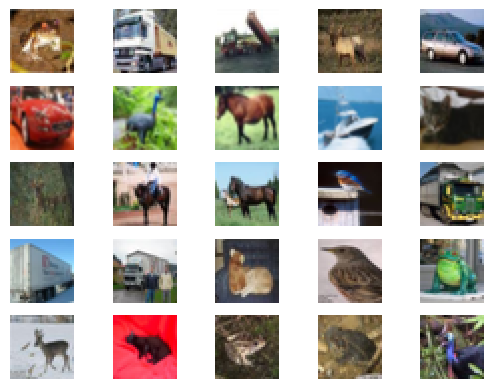

In [5]:
(trainX, trainy), (testX, testy) = load_data()

# plot 25=5x5 example images
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(trainX[i])
plt.show()

In [6]:
# Load the cifar images and build a training data set
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    # convert to float and scale.
    X = trainX.astype('float32')
    # the generator uses tanh as activation function (see above), 
    # so we need to rescale from [0,255] to [-1,1]
    # original images to -1 to 1 to match the output of generator.
    X = (X - 127.5) / 127.5  
    
    return X

In [7]:
# Pick a batch of random real samples to train the GAN
# In fact, train the GAN on a half batch of real images and another half batch of fake images. 
# For each real image assign the label=1 and for fake assign the label=0. 
def generate_real_samples(dataset, n_samples):
    # choose random images
    ix = randint(0, dataset.shape[0], n_samples)
    # select the random images and assign it to X
    x = dataset[ix]
    # generate class labels with label smoothing (0.9 instead of 1.0)
    # This prevents discriminator from becoming overconfident
    y = ones((n_samples, 1)) * 0.9  # label smoothing: 0.9 instead of 1.0
    return x, y

In [8]:
# Generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [9]:
# Use the generator to generate n fake examples, with class labels
# Supply the generator, latent_dim and number of samples as input.
# Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict using generator to generate fake samples (verbose=0 to suppress progress bar)
    x = generator.predict(x_input, verbose=0)
    # Class labels will be 0 as these samples are fake. 
    y = zeros((n_samples, 1))  # label=0 indicates that the image is a fake one
    return x, y

### Training function for the generator and discriminator
Loop through a number of epochs to train the discriminator by first selecting a random batch of images from the true/real data set. Then, generate a set of images using the generator. Feed both sets of images into the discriminator. Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 

In [10]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128, save_interval=50, model_suffix=""):
    """
    Train the GAN with periodic model checkpoints and loss tracking
    
    Args:
        g_model: Generator model
        d_model: Discriminator model
        gan_model: Combined GAN model
        dataset: Training dataset
        latent_dim: Dimension of latent space
        n_epochs: Total number of training epochs
        n_batch: Batch size
        save_interval: Save model every N epochs (default: 50)
        model_suffix: Optional suffix for model filenames (e.g., "_bn" for BatchNorm version)
    """
    
    # Create directory for saving models
    save_dir = "ex8_models"
    os.makedirs(save_dir, exist_ok=True)
    print(f"Models will be saved to: {save_dir}/")
    
    # Initialize loss history tracking
    history = {
        'd_loss_real': [],
        'd_loss_fake': [],
        'g_loss': []
    }
    
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)  # the discriminator model is updated for a half batch of real samples 
                            # and a half batch of fake samples, combined a single batch. 
    
    # manually enumerate epochs and batches. 
    for i in range(n_epochs):
        # Track losses for this epoch
        epoch_d_loss_real = []
        epoch_d_loss_fake = []
        epoch_g_loss = []
        
        # Create progress bar for this epoch
        pbar = tqdm(range(bat_per_epo), desc=f"Epoch {i+1}/{n_epochs}")
        
        # enumerate batches over the training set
        for j in pbar:
            
            # Train the discriminator on real and fake images, separately (half batch each)
            # Research showed that separate training is more effective. 
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            # train_on_batch allows you to update weights based on a collection 
            # of samples you provide
            # Let us just capture loss and ignore accuracy value (2nd output below)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            # d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Average loss if you want to report single..
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples as valid ones.
            # This is where the generator is trying to trick discriminator into believing that 
            # the generated image is true (hence value of 1 for y)
            y_gan = ones((n_batch, 1))
            
            # The generator is part of the combined model where it got directly linked with the discriminator
            # Train the generator with latent_dim as x and 1 as y. 
            # Again, 1 as the output as it is adversarial and if the generator did a great
            # job of fooling the discriminator, then the output would be 1 (true).
            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # Record batch losses
            epoch_d_loss_real.append(d_loss_real)
            epoch_d_loss_fake.append(d_loss_fake)
            epoch_g_loss.append(g_loss)
            
            # Update progress bar with current losses
            pbar.set_postfix({
                'D_real': f'{d_loss_real:.4f}',
                'D_fake': f'{d_loss_fake:.4f}',
                'G': f'{g_loss:.4f}'
            })
        
        # Calculate and store epoch average losses
        history['d_loss_real'].append(np.mean(epoch_d_loss_real))
        history['d_loss_fake'].append(np.mean(epoch_d_loss_fake))
        history['g_loss'].append(np.mean(epoch_g_loss))
        
        # Print epoch summary (clean output - one line per epoch)
        print(f"Epoch {i+1}/{n_epochs} - Avg D_real: {history['d_loss_real'][-1]:.4f}, Avg D_fake: {history['d_loss_fake'][-1]:.4f}, Avg G: {history['g_loss'][-1]:.4f}")
        
        # Save model checkpoint at specified intervals
        if (i + 1) % save_interval == 0:
            checkpoint_filename = f"{save_dir}/GAN_dim{latent_dim}{model_suffix}_epoch{i+1:03d}.keras"
            g_model.save(checkpoint_filename)
            print(f"  -> Checkpoint saved: {checkpoint_filename}")
    
    # Save the final model
    final_filename = f"{save_dir}/GAN_dim{latent_dim}{model_suffix}_epoch{n_epochs:03d}_final.keras"
    g_model.save(final_filename)
    print(f"\nFinal model saved: {final_filename}")
    
    # Save loss history to CSV
    import pandas as pd
    history_df = pd.DataFrame(history)
    history_df['epoch'] = range(1, n_epochs + 1)
    history_csv = f"{save_dir}/loss_history_dim{latent_dim}{model_suffix}_epoch{n_epochs}.csv"
    history_df.to_csv(history_csv, index=False)
    print(f"Loss history saved: {history_csv}\n")
    
    return history

### Train the GAN

In [11]:
# size of the latent space
latent_dim = 100  # EXPERIMENT: Testing BatchNorm with dim=100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()

# train model with checkpoints
n_epochs = 200  # Total training epochs
save_interval = 10  # Save model every 10 epochs

# This will save models to ex8_models/ directory with _bn suffix:
# - GAN_dim100_bn_epoch010.keras
# - GAN_dim100_bn_epoch020.keras
# - GAN_dim100_bn_epoch030.keras
# - ... (every 10 epochs)
# - GAN_dim100_bn_epoch200_final.keras

# Train and get loss history (with _bn suffix to distinguish from no-BN experiments)
history = train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs, save_interval=save_interval, model_suffix="_bn")

Models will be saved to: ex8_models/


Epoch 1/200:   0%|          | 0/390 [00:00<?, ?it/s]2025-11-15 17:58:22.283507: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-11-15 17:58:22.284392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-15 17:58:22.765146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-15 17:58:23.242418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Epoch 1/200: 100%|██████████| 390/390 [01:49<00:00,  3.57it/s, D_real=0.6156, D_fake=0.2822, G=0.8430]


Epoch 1/200 - Avg D_real: 0.5228, Avg D_fake: 0.2212, Avg G: 2.4326


Epoch 2/200: 100%|██████████| 390/390 [02:21<00:00,  2.76it/s, D_real=0.6153, D_fake=0.3781, G=0.3290]


Epoch 2/200 - Avg D_real: 0.6413, Avg D_fake: 0.5854, Avg G: 0.7248


Epoch 3/200: 100%|██████████| 390/390 [02:11<00:00,  2.96it/s, D_real=0.5432, D_fake=0.3600, G=0.1225]


Epoch 3/200 - Avg D_real: 0.7026, Avg D_fake: 0.3928, Avg G: 0.3674


Epoch 4/200: 100%|██████████| 390/390 [02:07<00:00,  3.06it/s, D_real=0.7797, D_fake=0.4715, G=0.8784]


Epoch 4/200 - Avg D_real: 0.6763, Avg D_fake: 0.4185, Avg G: 0.4398


Epoch 5/200: 100%|██████████| 390/390 [02:06<00:00,  3.08it/s, D_real=0.7090, D_fake=0.5666, G=1.1230]


Epoch 5/200 - Avg D_real: 0.6161, Avg D_fake: 0.3482, Avg G: 0.2115


Epoch 6/200: 100%|██████████| 390/390 [02:05<00:00,  3.10it/s, D_real=0.4554, D_fake=0.1469, G=0.0394]


Epoch 6/200 - Avg D_real: 0.5556, Avg D_fake: 0.2115, Avg G: 0.2159


Epoch 7/200: 100%|██████████| 390/390 [02:06<00:00,  3.07it/s, D_real=0.7416, D_fake=1.0278, G=0.6832]


Epoch 7/200 - Avg D_real: 0.5773, Avg D_fake: 0.2796, Avg G: 0.2541


Epoch 8/200: 100%|██████████| 390/390 [02:08<00:00,  3.03it/s, D_real=0.4328, D_fake=0.1720, G=0.0973]


Epoch 8/200 - Avg D_real: 0.6221, Avg D_fake: 0.3073, Avg G: 0.1710


Epoch 9/200: 100%|██████████| 390/390 [02:16<00:00,  2.87it/s, D_real=0.4466, D_fake=0.1092, G=0.0468]


Epoch 9/200 - Avg D_real: 0.6160, Avg D_fake: 0.2744, Avg G: 0.2516


Epoch 10/200: 100%|██████████| 390/390 [02:09<00:00,  3.00it/s, D_real=0.4552, D_fake=0.0426, G=0.0227]

Epoch 10/200 - Avg D_real: 0.5496, Avg D_fake: 0.2716, Avg G: 0.2507


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch010.keras


Epoch 11/200: 100%|██████████| 390/390 [02:18<00:00,  2.83it/s, D_real=0.4540, D_fake=0.2374, G=0.3216]


Epoch 11/200 - Avg D_real: 0.4682, Avg D_fake: 0.1345, Avg G: 0.1502


Epoch 12/200: 100%|██████████| 390/390 [02:26<00:00,  2.67it/s, D_real=0.7998, D_fake=0.4153, G=0.1925]


Epoch 12/200 - Avg D_real: 0.6241, Avg D_fake: 0.2643, Avg G: 0.2608


Epoch 13/200: 100%|██████████| 390/390 [02:27<00:00,  2.64it/s, D_real=0.6292, D_fake=0.3961, G=0.1470]


Epoch 13/200 - Avg D_real: 0.5609, Avg D_fake: 0.2011, Avg G: 0.2704


Epoch 14/200: 100%|██████████| 390/390 [02:19<00:00,  2.80it/s, D_real=0.4389, D_fake=0.1702, G=0.2264]


Epoch 14/200 - Avg D_real: 0.5372, Avg D_fake: 0.1874, Avg G: 0.2014


Epoch 15/200: 100%|██████████| 390/390 [02:16<00:00,  2.86it/s, D_real=0.7483, D_fake=0.1871, G=0.2374]


Epoch 15/200 - Avg D_real: 0.5772, Avg D_fake: 0.2183, Avg G: 0.3280


Epoch 16/200: 100%|██████████| 390/390 [02:20<00:00,  2.78it/s, D_real=0.5471, D_fake=0.2732, G=0.2935]


Epoch 16/200 - Avg D_real: 0.5763, Avg D_fake: 0.2449, Avg G: 0.2623


Epoch 17/200: 100%|██████████| 390/390 [02:25<00:00,  2.69it/s, D_real=0.5530, D_fake=0.1496, G=0.0626]


Epoch 17/200 - Avg D_real: 0.6783, Avg D_fake: 0.3099, Avg G: 0.5668


Epoch 18/200: 100%|██████████| 390/390 [02:10<00:00,  3.00it/s, D_real=0.4332, D_fake=0.1358, G=0.1404]


Epoch 18/200 - Avg D_real: 0.5512, Avg D_fake: 0.2215, Avg G: 0.2814


Epoch 19/200: 100%|██████████| 390/390 [02:05<00:00,  3.11it/s, D_real=0.7186, D_fake=0.3150, G=0.1612]


Epoch 19/200 - Avg D_real: 0.5449, Avg D_fake: 0.1945, Avg G: 0.3811


Epoch 20/200: 100%|██████████| 390/390 [02:14<00:00,  2.91it/s, D_real=0.4029, D_fake=0.0759, G=0.3908]

Epoch 20/200 - Avg D_real: 0.5875, Avg D_fake: 0.2192, Avg G: 0.4787


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch020.keras


Epoch 21/200: 100%|██████████| 390/390 [02:00<00:00,  3.22it/s, D_real=0.4241, D_fake=0.1166, G=0.0663]


Epoch 21/200 - Avg D_real: 0.5609, Avg D_fake: 0.1716, Avg G: 0.3497


Epoch 22/200: 100%|██████████| 390/390 [01:58<00:00,  3.29it/s, D_real=0.5461, D_fake=0.1566, G=0.0859]


Epoch 22/200 - Avg D_real: 0.5237, Avg D_fake: 0.1692, Avg G: 0.4323


Epoch 23/200: 100%|██████████| 390/390 [02:09<00:00,  3.01it/s, D_real=0.5129, D_fake=0.1225, G=0.1076]


Epoch 23/200 - Avg D_real: 0.5645, Avg D_fake: 0.1719, Avg G: 0.3088


Epoch 24/200: 100%|██████████| 390/390 [02:05<00:00,  3.11it/s, D_real=0.6115, D_fake=0.2618, G=0.3614]


Epoch 24/200 - Avg D_real: 0.5780, Avg D_fake: 0.2070, Avg G: 0.5024


Epoch 25/200: 100%|██████████| 390/390 [01:59<00:00,  3.27it/s, D_real=0.4146, D_fake=0.1009, G=0.0898]


Epoch 25/200 - Avg D_real: 0.5438, Avg D_fake: 0.1634, Avg G: 0.3281


Epoch 26/200: 100%|██████████| 390/390 [02:01<00:00,  3.22it/s, D_real=0.5543, D_fake=0.3073, G=1.1906]


Epoch 26/200 - Avg D_real: 0.5520, Avg D_fake: 0.1968, Avg G: 0.5075


Epoch 27/200: 100%|██████████| 390/390 [01:56<00:00,  3.34it/s, D_real=0.6143, D_fake=0.2681, G=0.1358]


Epoch 27/200 - Avg D_real: 0.6052, Avg D_fake: 0.2536, Avg G: 0.5392


Epoch 28/200: 100%|██████████| 390/390 [01:57<00:00,  3.31it/s, D_real=0.4643, D_fake=0.1795, G=0.1882]


Epoch 28/200 - Avg D_real: 0.6143, Avg D_fake: 0.2596, Avg G: 0.3535


Epoch 29/200: 100%|██████████| 390/390 [01:57<00:00,  3.31it/s, D_real=0.7607, D_fake=0.2528, G=0.0948]


Epoch 29/200 - Avg D_real: 0.7329, Avg D_fake: 0.3666, Avg G: 0.4965


Epoch 30/200: 100%|██████████| 390/390 [01:56<00:00,  3.34it/s, D_real=0.8343, D_fake=0.6602, G=0.7153]

Epoch 30/200 - Avg D_real: 0.6789, Avg D_fake: 0.3503, Avg G: 0.4594


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch030.keras


Epoch 31/200: 100%|██████████| 390/390 [02:13<00:00,  2.92it/s, D_real=0.6633, D_fake=0.3457, G=0.3578]


Epoch 31/200 - Avg D_real: 0.6786, Avg D_fake: 0.3549, Avg G: 0.6295


Epoch 32/200: 100%|██████████| 390/390 [02:22<00:00,  2.73it/s, D_real=0.5911, D_fake=0.1714, G=1.2372]


Epoch 32/200 - Avg D_real: 0.5896, Avg D_fake: 0.2782, Avg G: 0.3996


Epoch 33/200: 100%|██████████| 390/390 [02:14<00:00,  2.89it/s, D_real=0.8536, D_fake=0.5900, G=1.2454]


Epoch 33/200 - Avg D_real: 0.6591, Avg D_fake: 0.3549, Avg G: 0.7743


Epoch 34/200: 100%|██████████| 390/390 [01:56<00:00,  3.35it/s, D_real=0.4998, D_fake=0.3221, G=0.6229]


Epoch 34/200 - Avg D_real: 0.6690, Avg D_fake: 0.3597, Avg G: 0.6972


Epoch 35/200: 100%|██████████| 390/390 [01:55<00:00,  3.37it/s, D_real=0.6428, D_fake=0.2446, G=0.1210]


Epoch 35/200 - Avg D_real: 0.6160, Avg D_fake: 0.2815, Avg G: 0.6749


Epoch 36/200: 100%|██████████| 390/390 [01:56<00:00,  3.35it/s, D_real=0.9178, D_fake=0.4246, G=0.8637]


Epoch 36/200 - Avg D_real: 0.7107, Avg D_fake: 0.4075, Avg G: 0.8314


Epoch 37/200: 100%|██████████| 390/390 [02:01<00:00,  3.20it/s, D_real=0.7371, D_fake=0.6050, G=0.6645]


Epoch 37/200 - Avg D_real: 0.7343, Avg D_fake: 0.4628, Avg G: 0.9652


Epoch 38/200: 100%|██████████| 390/390 [01:55<00:00,  3.38it/s, D_real=0.6264, D_fake=0.5651, G=0.8110]


Epoch 38/200 - Avg D_real: 0.7352, Avg D_fake: 0.4515, Avg G: 0.7948


Epoch 39/200: 100%|██████████| 390/390 [01:56<00:00,  3.34it/s, D_real=0.5884, D_fake=0.2213, G=1.7178]


Epoch 39/200 - Avg D_real: 0.6911, Avg D_fake: 0.4127, Avg G: 0.8280


Epoch 40/200: 100%|██████████| 390/390 [01:56<00:00,  3.36it/s, D_real=0.6167, D_fake=0.2314, G=0.4198]

Epoch 40/200 - Avg D_real: 0.6259, Avg D_fake: 0.3017, Avg G: 0.7546


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch040.keras


Epoch 41/200: 100%|██████████| 390/390 [01:56<00:00,  3.34it/s, D_real=0.6446, D_fake=0.2709, G=0.7091]


Epoch 41/200 - Avg D_real: 0.6954, Avg D_fake: 0.3933, Avg G: 0.8178


Epoch 42/200: 100%|██████████| 390/390 [01:56<00:00,  3.33it/s, D_real=0.5209, D_fake=0.1578, G=0.7198]


Epoch 42/200 - Avg D_real: 0.6647, Avg D_fake: 0.3306, Avg G: 0.8592


Epoch 43/200: 100%|██████████| 390/390 [01:57<00:00,  3.31it/s, D_real=0.6171, D_fake=0.3070, G=0.5345]


Epoch 43/200 - Avg D_real: 0.7391, Avg D_fake: 0.4255, Avg G: 0.7312


Epoch 44/200: 100%|██████████| 390/390 [01:59<00:00,  3.26it/s, D_real=0.7607, D_fake=0.2434, G=0.5477]


Epoch 44/200 - Avg D_real: 0.6862, Avg D_fake: 0.3585, Avg G: 0.6772


Epoch 45/200: 100%|██████████| 390/390 [02:02<00:00,  3.17it/s, D_real=0.5802, D_fake=0.3163, G=0.4201]


Epoch 45/200 - Avg D_real: 0.6404, Avg D_fake: 0.3239, Avg G: 0.7166


Epoch 46/200: 100%|██████████| 390/390 [02:02<00:00,  3.19it/s, D_real=0.6677, D_fake=0.2742, G=2.3566]


Epoch 46/200 - Avg D_real: 0.6632, Avg D_fake: 0.3226, Avg G: 0.8301


Epoch 47/200: 100%|██████████| 390/390 [02:02<00:00,  3.18it/s, D_real=0.7972, D_fake=0.4984, G=1.0240]


Epoch 47/200 - Avg D_real: 0.7184, Avg D_fake: 0.3909, Avg G: 0.8968


Epoch 48/200: 100%|██████████| 390/390 [02:02<00:00,  3.18it/s, D_real=0.6802, D_fake=0.3640, G=0.6394]


Epoch 48/200 - Avg D_real: 0.7403, Avg D_fake: 0.4452, Avg G: 0.8164


Epoch 49/200: 100%|██████████| 390/390 [02:01<00:00,  3.20it/s, D_real=0.7135, D_fake=0.3285, G=0.4467]


Epoch 49/200 - Avg D_real: 0.6848, Avg D_fake: 0.3687, Avg G: 0.8254


Epoch 50/200: 100%|██████████| 390/390 [02:03<00:00,  3.17it/s, D_real=0.5511, D_fake=0.2618, G=0.3282]

Epoch 50/200 - Avg D_real: 0.6745, Avg D_fake: 0.3519, Avg G: 0.7285


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch050.keras


Epoch 51/200: 100%|██████████| 390/390 [02:44<00:00,  2.37it/s, D_real=0.5995, D_fake=0.3771, G=0.7494]


Epoch 51/200 - Avg D_real: 0.7063, Avg D_fake: 0.3875, Avg G: 0.8323


Epoch 52/200: 100%|██████████| 390/390 [02:24<00:00,  2.70it/s, D_real=0.6807, D_fake=0.5772, G=1.0487]


Epoch 52/200 - Avg D_real: 0.6354, Avg D_fake: 0.2836, Avg G: 0.8663


Epoch 53/200: 100%|██████████| 390/390 [02:45<00:00,  2.36it/s, D_real=0.6904, D_fake=0.2889, G=0.2483]


Epoch 53/200 - Avg D_real: 0.7116, Avg D_fake: 0.3784, Avg G: 0.7667


Epoch 54/200: 100%|██████████| 390/390 [02:48<00:00,  2.31it/s, D_real=0.7898, D_fake=0.3889, G=0.4970]


Epoch 54/200 - Avg D_real: 0.6909, Avg D_fake: 0.3609, Avg G: 0.8448


Epoch 55/200: 100%|██████████| 390/390 [02:31<00:00,  2.58it/s, D_real=0.5125, D_fake=0.2036, G=0.4648]


Epoch 55/200 - Avg D_real: 0.5928, Avg D_fake: 0.2690, Avg G: 0.4940


Epoch 56/200: 100%|██████████| 390/390 [02:16<00:00,  2.85it/s, D_real=0.7730, D_fake=0.4578, G=0.9461]


Epoch 56/200 - Avg D_real: 0.6971, Avg D_fake: 0.3780, Avg G: 0.7684


Epoch 57/200: 100%|██████████| 390/390 [02:05<00:00,  3.10it/s, D_real=0.5266, D_fake=0.2954, G=0.1636]


Epoch 57/200 - Avg D_real: 0.6849, Avg D_fake: 0.3452, Avg G: 0.5933


Epoch 58/200: 100%|██████████| 390/390 [02:21<00:00,  2.76it/s, D_real=0.5766, D_fake=0.4435, G=0.2429]


Epoch 58/200 - Avg D_real: 0.6683, Avg D_fake: 0.3404, Avg G: 0.7554


Epoch 59/200: 100%|██████████| 390/390 [02:34<00:00,  2.52it/s, D_real=0.8010, D_fake=0.5031, G=0.8103]


Epoch 59/200 - Avg D_real: 0.7122, Avg D_fake: 0.3772, Avg G: 0.8118


Epoch 60/200: 100%|██████████| 390/390 [02:08<00:00,  3.03it/s, D_real=0.6501, D_fake=0.3188, G=1.4722]

Epoch 60/200 - Avg D_real: 0.6187, Avg D_fake: 0.2663, Avg G: 0.7136


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch060.keras


Epoch 61/200: 100%|██████████| 390/390 [02:04<00:00,  3.14it/s, D_real=0.6054, D_fake=0.4499, G=0.3597]


Epoch 61/200 - Avg D_real: 0.7099, Avg D_fake: 0.3671, Avg G: 0.7950


Epoch 62/200: 100%|██████████| 390/390 [02:02<00:00,  3.20it/s, D_real=0.5524, D_fake=0.1960, G=0.2424]


Epoch 62/200 - Avg D_real: 0.6060, Avg D_fake: 0.2542, Avg G: 0.6723


Epoch 63/200: 100%|██████████| 390/390 [02:01<00:00,  3.22it/s, D_real=0.7297, D_fake=0.3770, G=0.6196]


Epoch 63/200 - Avg D_real: 0.7049, Avg D_fake: 0.3751, Avg G: 0.7410


Epoch 64/200: 100%|██████████| 390/390 [02:00<00:00,  3.23it/s, D_real=0.7870, D_fake=0.4335, G=0.8456]


Epoch 64/200 - Avg D_real: 0.7074, Avg D_fake: 0.4035, Avg G: 0.7691


Epoch 65/200: 100%|██████████| 390/390 [02:02<00:00,  3.17it/s, D_real=0.6109, D_fake=0.1725, G=0.9548]


Epoch 65/200 - Avg D_real: 0.7174, Avg D_fake: 0.3932, Avg G: 0.7005


Epoch 66/200: 100%|██████████| 390/390 [02:01<00:00,  3.21it/s, D_real=0.5980, D_fake=0.3394, G=0.3621]


Epoch 66/200 - Avg D_real: 0.6520, Avg D_fake: 0.3042, Avg G: 0.7008


Epoch 67/200: 100%|██████████| 390/390 [02:00<00:00,  3.23it/s, D_real=0.5422, D_fake=0.3223, G=0.4168]


Epoch 67/200 - Avg D_real: 0.7343, Avg D_fake: 0.4035, Avg G: 0.8914


Epoch 68/200: 100%|██████████| 390/390 [02:00<00:00,  3.23it/s, D_real=0.5902, D_fake=0.2350, G=2.0815]


Epoch 68/200 - Avg D_real: 0.6972, Avg D_fake: 0.3645, Avg G: 0.7601


Epoch 69/200: 100%|██████████| 390/390 [02:00<00:00,  3.24it/s, D_real=0.5935, D_fake=0.3695, G=0.2750]


Epoch 69/200 - Avg D_real: 0.6845, Avg D_fake: 0.3527, Avg G: 0.7685


Epoch 70/200: 100%|██████████| 390/390 [02:18<00:00,  2.82it/s, D_real=0.5995, D_fake=0.3804, G=0.4423]

Epoch 70/200 - Avg D_real: 0.7108, Avg D_fake: 0.3977, Avg G: 0.8078


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch070.keras


Epoch 71/200: 100%|██████████| 390/390 [02:20<00:00,  2.77it/s, D_real=0.8971, D_fake=0.4821, G=0.7444]


Epoch 71/200 - Avg D_real: 0.7232, Avg D_fake: 0.4170, Avg G: 0.9742


Epoch 72/200: 100%|██████████| 390/390 [02:25<00:00,  2.68it/s, D_real=0.6107, D_fake=0.2816, G=1.0897]


Epoch 72/200 - Avg D_real: 0.6968, Avg D_fake: 0.3966, Avg G: 0.8590


Epoch 73/200: 100%|██████████| 390/390 [02:27<00:00,  2.65it/s, D_real=0.6920, D_fake=0.2856, G=0.8008]


Epoch 73/200 - Avg D_real: 0.7109, Avg D_fake: 0.3659, Avg G: 0.8221


Epoch 74/200: 100%|██████████| 390/390 [02:25<00:00,  2.69it/s, D_real=0.8298, D_fake=0.5640, G=1.0581]


Epoch 74/200 - Avg D_real: 0.7482, Avg D_fake: 0.4414, Avg G: 0.8402


Epoch 75/200: 100%|██████████| 390/390 [02:23<00:00,  2.71it/s, D_real=0.8466, D_fake=0.3374, G=0.9851]


Epoch 75/200 - Avg D_real: 0.7398, Avg D_fake: 0.4217, Avg G: 0.9460


Epoch 76/200: 100%|██████████| 390/390 [02:23<00:00,  2.72it/s, D_real=0.7309, D_fake=0.3731, G=0.5319]


Epoch 76/200 - Avg D_real: 0.7022, Avg D_fake: 0.4081, Avg G: 0.9297


Epoch 77/200: 100%|██████████| 390/390 [02:23<00:00,  2.72it/s, D_real=0.6944, D_fake=0.3403, G=0.6528]


Epoch 77/200 - Avg D_real: 0.7096, Avg D_fake: 0.4003, Avg G: 0.8409


Epoch 78/200: 100%|██████████| 390/390 [02:23<00:00,  2.72it/s, D_real=0.6891, D_fake=0.4665, G=0.5494]


Epoch 78/200 - Avg D_real: 0.7143, Avg D_fake: 0.3971, Avg G: 0.9150


Epoch 79/200: 100%|██████████| 390/390 [02:30<00:00,  2.60it/s, D_real=0.5541, D_fake=0.3210, G=1.0779]


Epoch 79/200 - Avg D_real: 0.6875, Avg D_fake: 0.3719, Avg G: 0.8526


Epoch 80/200: 100%|██████████| 390/390 [02:38<00:00,  2.45it/s, D_real=0.7060, D_fake=0.4538, G=1.2042]

Epoch 80/200 - Avg D_real: 0.7874, Avg D_fake: 0.4900, Avg G: 0.9860


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch080.keras


Epoch 81/200: 100%|██████████| 390/390 [02:31<00:00,  2.57it/s, D_real=0.7219, D_fake=0.3655, G=1.4993]


Epoch 81/200 - Avg D_real: 0.7130, Avg D_fake: 0.4134, Avg G: 0.9776


Epoch 82/200: 100%|██████████| 390/390 [02:34<00:00,  2.52it/s, D_real=0.7310, D_fake=0.4707, G=0.3349]


Epoch 82/200 - Avg D_real: 0.7886, Avg D_fake: 0.4552, Avg G: 0.9634


Epoch 83/200: 100%|██████████| 390/390 [02:27<00:00,  2.64it/s, D_real=0.7788, D_fake=0.4795, G=1.3316]


Epoch 83/200 - Avg D_real: 0.7241, Avg D_fake: 0.4135, Avg G: 0.9745


Epoch 84/200: 100%|██████████| 390/390 [02:25<00:00,  2.68it/s, D_real=0.8122, D_fake=0.4355, G=0.8192]


Epoch 84/200 - Avg D_real: 0.7299, Avg D_fake: 0.4277, Avg G: 1.0533


Epoch 85/200: 100%|██████████| 390/390 [02:29<00:00,  2.60it/s, D_real=0.6772, D_fake=0.4557, G=0.8025]


Epoch 85/200 - Avg D_real: 0.7303, Avg D_fake: 0.4195, Avg G: 1.0185


Epoch 86/200: 100%|██████████| 390/390 [02:24<00:00,  2.71it/s, D_real=0.7516, D_fake=0.3540, G=1.1510]


Epoch 86/200 - Avg D_real: 0.7154, Avg D_fake: 0.4152, Avg G: 1.0758


Epoch 87/200: 100%|██████████| 390/390 [02:22<00:00,  2.73it/s, D_real=0.9288, D_fake=0.5365, G=0.6177]


Epoch 87/200 - Avg D_real: 0.7677, Avg D_fake: 0.4614, Avg G: 0.9900


Epoch 88/200: 100%|██████████| 390/390 [02:23<00:00,  2.71it/s, D_real=0.7891, D_fake=0.4606, G=0.8724]


Epoch 88/200 - Avg D_real: 0.7268, Avg D_fake: 0.4241, Avg G: 0.9514


Epoch 89/200: 100%|██████████| 390/390 [02:24<00:00,  2.70it/s, D_real=0.7469, D_fake=0.3748, G=0.5637]


Epoch 89/200 - Avg D_real: 0.7266, Avg D_fake: 0.4067, Avg G: 0.9056


Epoch 90/200: 100%|██████████| 390/390 [02:20<00:00,  2.77it/s, D_real=0.5417, D_fake=0.3595, G=0.4120]

Epoch 90/200 - Avg D_real: 0.6725, Avg D_fake: 0.3464, Avg G: 0.9146


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch090.keras


Epoch 91/200: 100%|██████████| 390/390 [02:21<00:00,  2.75it/s, D_real=0.6335, D_fake=0.4319, G=0.9660]


Epoch 91/200 - Avg D_real: 0.7259, Avg D_fake: 0.4259, Avg G: 1.0366


Epoch 92/200: 100%|██████████| 390/390 [02:25<00:00,  2.68it/s, D_real=0.7305, D_fake=0.3319, G=0.5091]


Epoch 92/200 - Avg D_real: 0.6801, Avg D_fake: 0.3374, Avg G: 0.7092


Epoch 93/200: 100%|██████████| 390/390 [02:21<00:00,  2.76it/s, D_real=0.7699, D_fake=0.4455, G=0.7650]


Epoch 93/200 - Avg D_real: 0.7803, Avg D_fake: 0.4723, Avg G: 1.0556


Epoch 94/200: 100%|██████████| 390/390 [02:21<00:00,  2.75it/s, D_real=0.7338, D_fake=0.4269, G=1.1963]


Epoch 94/200 - Avg D_real: 0.7449, Avg D_fake: 0.4319, Avg G: 1.0486


Epoch 95/200: 100%|██████████| 390/390 [02:22<00:00,  2.73it/s, D_real=0.6870, D_fake=0.3736, G=0.6437]


Epoch 95/200 - Avg D_real: 0.7171, Avg D_fake: 0.4104, Avg G: 0.9106


Epoch 96/200: 100%|██████████| 390/390 [02:23<00:00,  2.71it/s, D_real=0.7995, D_fake=0.5417, G=0.6076]


Epoch 96/200 - Avg D_real: 0.7068, Avg D_fake: 0.3706, Avg G: 0.9649


Epoch 97/200: 100%|██████████| 390/390 [02:20<00:00,  2.78it/s, D_real=0.6894, D_fake=0.5112, G=0.8587]


Epoch 97/200 - Avg D_real: 0.6758, Avg D_fake: 0.3362, Avg G: 0.9965


Epoch 98/200: 100%|██████████| 390/390 [02:22<00:00,  2.74it/s, D_real=0.5839, D_fake=0.2563, G=1.0474]


Epoch 98/200 - Avg D_real: 0.7308, Avg D_fake: 0.3848, Avg G: 0.9698


Epoch 99/200: 100%|██████████| 390/390 [02:24<00:00,  2.70it/s, D_real=0.7629, D_fake=0.4073, G=1.0624]


Epoch 99/200 - Avg D_real: 0.6585, Avg D_fake: 0.3276, Avg G: 0.8920


Epoch 100/200: 100%|██████████| 390/390 [02:20<00:00,  2.77it/s, D_real=0.7651, D_fake=0.1493, G=1.0999]

Epoch 100/200 - Avg D_real: 0.6870, Avg D_fake: 0.3264, Avg G: 0.8857


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch100.keras


Epoch 101/200: 100%|██████████| 390/390 [02:21<00:00,  2.76it/s, D_real=0.8584, D_fake=0.4166, G=0.8525]


Epoch 101/200 - Avg D_real: 0.6614, Avg D_fake: 0.2939, Avg G: 0.8862


Epoch 102/200: 100%|██████████| 390/390 [02:22<00:00,  2.74it/s, D_real=0.6913, D_fake=0.3571, G=0.5325]


Epoch 102/200 - Avg D_real: 0.7531, Avg D_fake: 0.4401, Avg G: 1.0981


Epoch 103/200: 100%|██████████| 390/390 [02:22<00:00,  2.74it/s, D_real=0.8367, D_fake=0.4729, G=0.6952]


Epoch 103/200 - Avg D_real: 0.6938, Avg D_fake: 0.3805, Avg G: 1.2472


Epoch 104/200: 100%|██████████| 390/390 [02:23<00:00,  2.72it/s, D_real=0.7835, D_fake=0.3688, G=0.7784]


Epoch 104/200 - Avg D_real: 0.7213, Avg D_fake: 0.4119, Avg G: 0.9161


Epoch 105/200: 100%|██████████| 390/390 [02:24<00:00,  2.69it/s, D_real=0.9020, D_fake=0.4371, G=1.1091]


Epoch 105/200 - Avg D_real: 0.7916, Avg D_fake: 0.4954, Avg G: 1.0312


Epoch 106/200: 100%|██████████| 390/390 [02:22<00:00,  2.74it/s, D_real=0.6603, D_fake=0.3253, G=0.0974]


Epoch 106/200 - Avg D_real: 0.7590, Avg D_fake: 0.4410, Avg G: 0.8658


Epoch 107/200: 100%|██████████| 390/390 [02:20<00:00,  2.77it/s, D_real=0.6167, D_fake=0.2775, G=0.5902]


Epoch 107/200 - Avg D_real: 0.6865, Avg D_fake: 0.3937, Avg G: 0.9688


Epoch 108/200: 100%|██████████| 390/390 [02:22<00:00,  2.74it/s, D_real=0.8848, D_fake=0.6597, G=0.8862]


Epoch 108/200 - Avg D_real: 0.7655, Avg D_fake: 0.4665, Avg G: 1.0749


Epoch 109/200: 100%|██████████| 390/390 [02:21<00:00,  2.76it/s, D_real=0.6582, D_fake=0.4455, G=0.3015]


Epoch 109/200 - Avg D_real: 0.7949, Avg D_fake: 0.5020, Avg G: 1.0389


Epoch 110/200: 100%|██████████| 390/390 [02:23<00:00,  2.71it/s, D_real=0.5815, D_fake=0.2629, G=1.1335]

Epoch 110/200 - Avg D_real: 0.7198, Avg D_fake: 0.4274, Avg G: 1.0380


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch110.keras


Epoch 111/200: 100%|██████████| 390/390 [02:19<00:00,  2.80it/s, D_real=0.5882, D_fake=0.3075, G=0.5530]


Epoch 111/200 - Avg D_real: 0.7387, Avg D_fake: 0.4400, Avg G: 1.1474


Epoch 112/200: 100%|██████████| 390/390 [02:14<00:00,  2.89it/s, D_real=0.8596, D_fake=0.6136, G=1.2251]


Epoch 112/200 - Avg D_real: 0.6962, Avg D_fake: 0.3735, Avg G: 1.0332


Epoch 113/200: 100%|██████████| 390/390 [02:13<00:00,  2.93it/s, D_real=0.8863, D_fake=0.3898, G=1.0813]


Epoch 113/200 - Avg D_real: 0.7456, Avg D_fake: 0.4118, Avg G: 1.0871


Epoch 114/200: 100%|██████████| 390/390 [02:17<00:00,  2.84it/s, D_real=0.6795, D_fake=0.4522, G=0.8061]


Epoch 114/200 - Avg D_real: 0.7328, Avg D_fake: 0.4240, Avg G: 0.9842


Epoch 115/200: 100%|██████████| 390/390 [02:14<00:00,  2.90it/s, D_real=0.8773, D_fake=0.4966, G=1.4933]


Epoch 115/200 - Avg D_real: 0.7299, Avg D_fake: 0.4327, Avg G: 1.0624


Epoch 116/200: 100%|██████████| 390/390 [02:13<00:00,  2.93it/s, D_real=0.6218, D_fake=0.2879, G=1.2494]


Epoch 116/200 - Avg D_real: 0.7160, Avg D_fake: 0.3990, Avg G: 0.9718


Epoch 117/200: 100%|██████████| 390/390 [02:15<00:00,  2.87it/s, D_real=0.8673, D_fake=0.5215, G=0.9873]


Epoch 117/200 - Avg D_real: 0.7750, Avg D_fake: 0.4781, Avg G: 1.0802


Epoch 118/200: 100%|██████████| 390/390 [02:15<00:00,  2.89it/s, D_real=0.9170, D_fake=0.3804, G=1.5235]


Epoch 118/200 - Avg D_real: 0.7089, Avg D_fake: 0.3932, Avg G: 1.1300


Epoch 119/200: 100%|██████████| 390/390 [02:13<00:00,  2.92it/s, D_real=0.5634, D_fake=0.3046, G=1.2974]


Epoch 119/200 - Avg D_real: 0.7383, Avg D_fake: 0.4283, Avg G: 1.0388


Epoch 120/200: 100%|██████████| 390/390 [02:15<00:00,  2.88it/s, D_real=0.7504, D_fake=0.4669, G=0.7346]

Epoch 120/200 - Avg D_real: 0.6514, Avg D_fake: 0.3313, Avg G: 1.0779


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch120.keras


Epoch 121/200: 100%|██████████| 390/390 [02:16<00:00,  2.86it/s, D_real=0.8419, D_fake=0.4470, G=0.9459]


Epoch 121/200 - Avg D_real: 0.7160, Avg D_fake: 0.4062, Avg G: 0.7737


Epoch 122/200: 100%|██████████| 390/390 [02:13<00:00,  2.91it/s, D_real=0.6238, D_fake=0.4917, G=0.9906]


Epoch 122/200 - Avg D_real: 0.7631, Avg D_fake: 0.4722, Avg G: 1.0532


Epoch 123/200: 100%|██████████| 390/390 [02:16<00:00,  2.86it/s, D_real=0.8232, D_fake=0.2810, G=1.1613]


Epoch 123/200 - Avg D_real: 0.7593, Avg D_fake: 0.4354, Avg G: 1.0893


Epoch 124/200: 100%|██████████| 390/390 [02:17<00:00,  2.84it/s, D_real=0.7639, D_fake=0.5215, G=0.9731]


Epoch 124/200 - Avg D_real: 0.7673, Avg D_fake: 0.4880, Avg G: 1.0467


Epoch 125/200: 100%|██████████| 390/390 [02:13<00:00,  2.92it/s, D_real=0.6329, D_fake=0.3797, G=0.6993]


Epoch 125/200 - Avg D_real: 0.7472, Avg D_fake: 0.4473, Avg G: 1.0746


Epoch 126/200: 100%|██████████| 390/390 [02:13<00:00,  2.91it/s, D_real=0.7170, D_fake=0.4442, G=1.3050]


Epoch 126/200 - Avg D_real: 0.6699, Avg D_fake: 0.3466, Avg G: 0.9686


Epoch 127/200: 100%|██████████| 390/390 [02:13<00:00,  2.91it/s, D_real=0.7291, D_fake=0.2829, G=1.9550]


Epoch 127/200 - Avg D_real: 0.7364, Avg D_fake: 0.4140, Avg G: 1.0543


Epoch 128/200: 100%|██████████| 390/390 [02:12<00:00,  2.95it/s, D_real=0.7752, D_fake=0.4221, G=1.0382]


Epoch 128/200 - Avg D_real: 0.7055, Avg D_fake: 0.3778, Avg G: 1.0258


Epoch 129/200: 100%|██████████| 390/390 [02:10<00:00,  3.00it/s, D_real=0.7960, D_fake=0.4592, G=0.9006]


Epoch 129/200 - Avg D_real: 0.7499, Avg D_fake: 0.4443, Avg G: 1.0730


Epoch 130/200: 100%|██████████| 390/390 [02:11<00:00,  2.97it/s, D_real=0.8923, D_fake=0.4860, G=1.2258]

Epoch 130/200 - Avg D_real: 0.7891, Avg D_fake: 0.5059, Avg G: 1.0010


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch130.keras


Epoch 131/200: 100%|██████████| 390/390 [02:10<00:00,  2.98it/s, D_real=0.7211, D_fake=0.4071, G=0.7766]


Epoch 131/200 - Avg D_real: 0.7302, Avg D_fake: 0.4314, Avg G: 1.1031


Epoch 132/200: 100%|██████████| 390/390 [02:09<00:00,  3.02it/s, D_real=0.7343, D_fake=0.4669, G=0.8695]


Epoch 132/200 - Avg D_real: 0.7411, Avg D_fake: 0.4293, Avg G: 1.0987


Epoch 133/200: 100%|██████████| 390/390 [02:09<00:00,  3.02it/s, D_real=0.7471, D_fake=0.4676, G=1.0454]


Epoch 133/200 - Avg D_real: 0.7384, Avg D_fake: 0.4445, Avg G: 1.0383


Epoch 134/200: 100%|██████████| 390/390 [02:11<00:00,  2.98it/s, D_real=0.7369, D_fake=0.3684, G=1.5724]


Epoch 134/200 - Avg D_real: 0.7642, Avg D_fake: 0.4697, Avg G: 1.0527


Epoch 135/200: 100%|██████████| 390/390 [02:12<00:00,  2.94it/s, D_real=0.5502, D_fake=0.3324, G=1.9519]


Epoch 135/200 - Avg D_real: 0.7484, Avg D_fake: 0.4472, Avg G: 1.0760


Epoch 136/200: 100%|██████████| 390/390 [02:11<00:00,  2.97it/s, D_real=0.6126, D_fake=0.3644, G=2.0386]


Epoch 136/200 - Avg D_real: 0.7367, Avg D_fake: 0.4210, Avg G: 1.0264


Epoch 137/200: 100%|██████████| 390/390 [02:09<00:00,  3.01it/s, D_real=0.7319, D_fake=0.4928, G=1.3288]


Epoch 137/200 - Avg D_real: 0.7591, Avg D_fake: 0.4761, Avg G: 1.0642


Epoch 138/200: 100%|██████████| 390/390 [02:13<00:00,  2.92it/s, D_real=0.6659, D_fake=0.2310, G=2.2020]


Epoch 138/200 - Avg D_real: 0.7240, Avg D_fake: 0.4304, Avg G: 0.9353


Epoch 139/200: 100%|██████████| 390/390 [02:09<00:00,  3.00it/s, D_real=0.7678, D_fake=0.4460, G=0.5712]


Epoch 139/200 - Avg D_real: 0.7592, Avg D_fake: 0.4661, Avg G: 1.0982


Epoch 140/200: 100%|██████████| 390/390 [02:09<00:00,  3.02it/s, D_real=0.7768, D_fake=0.3901, G=0.4114]

Epoch 140/200 - Avg D_real: 0.7430, Avg D_fake: 0.4430, Avg G: 1.0464


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch140.keras


Epoch 141/200: 100%|██████████| 390/390 [02:11<00:00,  2.96it/s, D_real=0.8770, D_fake=0.4915, G=1.0031]


Epoch 141/200 - Avg D_real: 0.7534, Avg D_fake: 0.4686, Avg G: 1.0642


Epoch 142/200: 100%|██████████| 390/390 [02:12<00:00,  2.95it/s, D_real=1.0236, D_fake=0.6540, G=0.8105]


Epoch 142/200 - Avg D_real: 0.7853, Avg D_fake: 0.5126, Avg G: 1.0157


Epoch 143/200: 100%|██████████| 390/390 [02:09<00:00,  3.02it/s, D_real=0.7388, D_fake=0.2966, G=1.0806]


Epoch 143/200 - Avg D_real: 0.7364, Avg D_fake: 0.4483, Avg G: 1.0310


Epoch 144/200: 100%|██████████| 390/390 [02:13<00:00,  2.93it/s, D_real=0.7858, D_fake=0.4818, G=1.0548]


Epoch 144/200 - Avg D_real: 0.7752, Avg D_fake: 0.4777, Avg G: 1.0807


Epoch 145/200: 100%|██████████| 390/390 [02:15<00:00,  2.88it/s, D_real=0.7234, D_fake=0.4662, G=1.1052]


Epoch 145/200 - Avg D_real: 0.7603, Avg D_fake: 0.4713, Avg G: 1.1077


Epoch 146/200: 100%|██████████| 390/390 [02:12<00:00,  2.95it/s, D_real=0.6447, D_fake=0.4034, G=1.1142]


Epoch 146/200 - Avg D_real: 0.7120, Avg D_fake: 0.4125, Avg G: 1.1071


Epoch 147/200: 100%|██████████| 390/390 [02:08<00:00,  3.03it/s, D_real=0.7105, D_fake=0.3509, G=1.0606]


Epoch 147/200 - Avg D_real: 0.7215, Avg D_fake: 0.3900, Avg G: 0.9893


Epoch 148/200: 100%|██████████| 390/390 [02:14<00:00,  2.91it/s, D_real=0.6602, D_fake=0.3387, G=1.1333]


Epoch 148/200 - Avg D_real: 0.7568, Avg D_fake: 0.4619, Avg G: 0.9550


Epoch 149/200: 100%|██████████| 390/390 [02:10<00:00,  2.99it/s, D_real=0.6955, D_fake=0.5139, G=1.0233]


Epoch 149/200 - Avg D_real: 0.7792, Avg D_fake: 0.4997, Avg G: 1.0347


Epoch 150/200: 100%|██████████| 390/390 [02:10<00:00,  2.98it/s, D_real=0.7626, D_fake=0.4617, G=1.0643]

Epoch 150/200 - Avg D_real: 0.7853, Avg D_fake: 0.4829, Avg G: 1.0420


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch150.keras


Epoch 151/200: 100%|██████████| 390/390 [02:10<00:00,  2.99it/s, D_real=0.5630, D_fake=0.4375, G=1.3887]


Epoch 151/200 - Avg D_real: 0.7198, Avg D_fake: 0.4285, Avg G: 1.0480


Epoch 152/200: 100%|██████████| 390/390 [02:10<00:00,  2.98it/s, D_real=0.8672, D_fake=0.5586, G=1.0329]


Epoch 152/200 - Avg D_real: 0.7484, Avg D_fake: 0.4609, Avg G: 1.1304


Epoch 153/200: 100%|██████████| 390/390 [02:09<00:00,  3.01it/s, D_real=0.6566, D_fake=0.3655, G=0.7654]


Epoch 153/200 - Avg D_real: 0.7417, Avg D_fake: 0.4639, Avg G: 1.0170


Epoch 154/200: 100%|██████████| 390/390 [02:09<00:00,  3.00it/s, D_real=0.7125, D_fake=0.6223, G=1.1313]


Epoch 154/200 - Avg D_real: 0.7275, Avg D_fake: 0.4389, Avg G: 1.0075


Epoch 155/200: 100%|██████████| 390/390 [02:09<00:00,  3.00it/s, D_real=0.6540, D_fake=0.3820, G=1.1819]


Epoch 155/200 - Avg D_real: 0.7440, Avg D_fake: 0.4628, Avg G: 1.1308


Epoch 156/200: 100%|██████████| 390/390 [02:09<00:00,  3.01it/s, D_real=0.7243, D_fake=0.5383, G=0.9648]


Epoch 156/200 - Avg D_real: 0.7563, Avg D_fake: 0.4737, Avg G: 1.1730


Epoch 157/200: 100%|██████████| 390/390 [02:09<00:00,  3.01it/s, D_real=0.6963, D_fake=0.5128, G=1.1161]


Epoch 157/200 - Avg D_real: 0.7405, Avg D_fake: 0.4643, Avg G: 1.0677


Epoch 158/200: 100%|██████████| 390/390 [02:13<00:00,  2.92it/s, D_real=0.6051, D_fake=0.3684, G=0.5863]


Epoch 158/200 - Avg D_real: 0.7334, Avg D_fake: 0.4488, Avg G: 0.9733


Epoch 159/200: 100%|██████████| 390/390 [02:09<00:00,  3.01it/s, D_real=0.7414, D_fake=0.4110, G=1.2771]


Epoch 159/200 - Avg D_real: 0.7114, Avg D_fake: 0.3981, Avg G: 1.1551


Epoch 160/200: 100%|██████████| 390/390 [02:10<00:00,  2.98it/s, D_real=0.6380, D_fake=0.4967, G=1.2333]

Epoch 160/200 - Avg D_real: 0.7081, Avg D_fake: 0.4215, Avg G: 1.1109


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch160.keras


Epoch 161/200: 100%|██████████| 390/390 [02:09<00:00,  3.00it/s, D_real=0.7440, D_fake=0.4177, G=1.2413]


Epoch 161/200 - Avg D_real: 0.7442, Avg D_fake: 0.4311, Avg G: 1.0842


Epoch 162/200: 100%|██████████| 390/390 [02:12<00:00,  2.94it/s, D_real=0.7571, D_fake=0.4552, G=0.9268]


Epoch 162/200 - Avg D_real: 0.7577, Avg D_fake: 0.4347, Avg G: 1.0369


Epoch 163/200: 100%|██████████| 390/390 [02:16<00:00,  2.87it/s, D_real=0.5976, D_fake=0.3582, G=0.8753]


Epoch 163/200 - Avg D_real: 0.7641, Avg D_fake: 0.4676, Avg G: 0.9958


Epoch 164/200: 100%|██████████| 390/390 [02:11<00:00,  2.97it/s, D_real=0.6755, D_fake=0.3170, G=1.1438]


Epoch 164/200 - Avg D_real: 0.7438, Avg D_fake: 0.4417, Avg G: 1.0731


Epoch 165/200: 100%|██████████| 390/390 [02:11<00:00,  2.96it/s, D_real=0.7067, D_fake=0.4248, G=1.3486]


Epoch 165/200 - Avg D_real: 0.7380, Avg D_fake: 0.4196, Avg G: 1.0345


Epoch 166/200: 100%|██████████| 390/390 [02:09<00:00,  3.00it/s, D_real=0.7273, D_fake=0.2867, G=1.6245]


Epoch 166/200 - Avg D_real: 0.7588, Avg D_fake: 0.4541, Avg G: 0.9734


Epoch 167/200: 100%|██████████| 390/390 [02:10<00:00,  2.99it/s, D_real=0.7409, D_fake=0.4800, G=1.0169]


Epoch 167/200 - Avg D_real: 0.7504, Avg D_fake: 0.4696, Avg G: 1.0748


Epoch 168/200: 100%|██████████| 390/390 [02:10<00:00,  2.99it/s, D_real=0.7444, D_fake=0.7259, G=0.6448]


Epoch 168/200 - Avg D_real: 0.7383, Avg D_fake: 0.4458, Avg G: 1.0381


Epoch 169/200: 100%|██████████| 390/390 [02:09<00:00,  3.00it/s, D_real=0.7839, D_fake=0.5062, G=0.9323]


Epoch 169/200 - Avg D_real: 0.7762, Avg D_fake: 0.4686, Avg G: 1.0625


Epoch 170/200: 100%|██████████| 390/390 [02:05<00:00,  3.11it/s, D_real=0.6649, D_fake=0.4890, G=1.4146]

Epoch 170/200 - Avg D_real: 0.7526, Avg D_fake: 0.4704, Avg G: 1.0631


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch170.keras


Epoch 171/200: 100%|██████████| 390/390 [02:05<00:00,  3.10it/s, D_real=0.7152, D_fake=0.4472, G=0.9688]


Epoch 171/200 - Avg D_real: 0.7727, Avg D_fake: 0.4827, Avg G: 0.9893


Epoch 172/200: 100%|██████████| 390/390 [02:08<00:00,  3.03it/s, D_real=0.7478, D_fake=0.4007, G=1.1987]


Epoch 172/200 - Avg D_real: 0.7349, Avg D_fake: 0.4400, Avg G: 1.1354


Epoch 173/200: 100%|██████████| 390/390 [02:04<00:00,  3.13it/s, D_real=0.7850, D_fake=0.4492, G=1.0962]


Epoch 173/200 - Avg D_real: 0.7559, Avg D_fake: 0.4735, Avg G: 1.0327


Epoch 174/200: 100%|██████████| 390/390 [02:04<00:00,  3.12it/s, D_real=0.8061, D_fake=0.4898, G=1.2036]


Epoch 174/200 - Avg D_real: 0.7386, Avg D_fake: 0.4549, Avg G: 1.0418


Epoch 175/200: 100%|██████████| 390/390 [02:06<00:00,  3.07it/s, D_real=0.7017, D_fake=0.3425, G=1.2776]


Epoch 175/200 - Avg D_real: 0.7342, Avg D_fake: 0.4328, Avg G: 1.0496


Epoch 176/200: 100%|██████████| 390/390 [02:04<00:00,  3.12it/s, D_real=0.5743, D_fake=0.2029, G=1.8198]


Epoch 176/200 - Avg D_real: 0.6974, Avg D_fake: 0.3676, Avg G: 0.9358


Epoch 177/200: 100%|██████████| 390/390 [02:04<00:00,  3.13it/s, D_real=0.6800, D_fake=0.5127, G=0.7992]


Epoch 177/200 - Avg D_real: 0.6975, Avg D_fake: 0.3720, Avg G: 1.2697


Epoch 178/200: 100%|██████████| 390/390 [02:05<00:00,  3.11it/s, D_real=0.7959, D_fake=0.5130, G=1.0310]


Epoch 178/200 - Avg D_real: 0.7312, Avg D_fake: 0.4210, Avg G: 1.2104


Epoch 179/200: 100%|██████████| 390/390 [02:05<00:00,  3.10it/s, D_real=0.7961, D_fake=0.4674, G=1.0643]


Epoch 179/200 - Avg D_real: 0.7722, Avg D_fake: 0.4714, Avg G: 1.0111


Epoch 180/200: 100%|██████████| 390/390 [02:04<00:00,  3.13it/s, D_real=0.7468, D_fake=0.3901, G=0.8554]

Epoch 180/200 - Avg D_real: 0.7617, Avg D_fake: 0.4963, Avg G: 1.0228


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch180.keras


Epoch 181/200: 100%|██████████| 390/390 [02:04<00:00,  3.12it/s, D_real=0.8746, D_fake=0.5284, G=1.0189]


Epoch 181/200 - Avg D_real: 0.7319, Avg D_fake: 0.4319, Avg G: 1.0710


Epoch 182/200: 100%|██████████| 390/390 [02:04<00:00,  3.13it/s, D_real=0.7246, D_fake=0.3953, G=1.0843]


Epoch 182/200 - Avg D_real: 0.7027, Avg D_fake: 0.3802, Avg G: 1.1245


Epoch 183/200: 100%|██████████| 390/390 [02:05<00:00,  3.12it/s, D_real=0.5797, D_fake=0.4494, G=0.8963]


Epoch 183/200 - Avg D_real: 0.7348, Avg D_fake: 0.4339, Avg G: 1.0375


Epoch 184/200: 100%|██████████| 390/390 [02:05<00:00,  3.12it/s, D_real=0.8080, D_fake=0.4424, G=0.8833]


Epoch 184/200 - Avg D_real: 0.7530, Avg D_fake: 0.4375, Avg G: 1.0761


Epoch 185/200: 100%|██████████| 390/390 [02:04<00:00,  3.14it/s, D_real=0.7881, D_fake=0.5045, G=0.6381]


Epoch 185/200 - Avg D_real: 0.7769, Avg D_fake: 0.4639, Avg G: 1.0537


Epoch 186/200: 100%|██████████| 390/390 [02:05<00:00,  3.12it/s, D_real=0.7054, D_fake=0.4235, G=1.3173]


Epoch 186/200 - Avg D_real: 0.7600, Avg D_fake: 0.4596, Avg G: 1.0565


Epoch 187/200: 100%|██████████| 390/390 [02:09<00:00,  3.01it/s, D_real=0.6657, D_fake=0.3833, G=1.0767]


Epoch 187/200 - Avg D_real: 0.7797, Avg D_fake: 0.4762, Avg G: 1.0735


Epoch 188/200: 100%|██████████| 390/390 [02:06<00:00,  3.07it/s, D_real=0.6486, D_fake=0.3292, G=0.3846]


Epoch 188/200 - Avg D_real: 0.7270, Avg D_fake: 0.4093, Avg G: 0.9506


Epoch 189/200: 100%|██████████| 390/390 [02:03<00:00,  3.15it/s, D_real=0.7680, D_fake=0.4925, G=1.1168]


Epoch 189/200 - Avg D_real: 0.7385, Avg D_fake: 0.4177, Avg G: 1.0860


Epoch 190/200: 100%|██████████| 390/390 [02:04<00:00,  3.12it/s, D_real=0.7213, D_fake=0.3463, G=1.0384]

Epoch 190/200 - Avg D_real: 0.7528, Avg D_fake: 0.4497, Avg G: 1.0420


  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch190.keras


Epoch 191/200: 100%|██████████| 390/390 [02:05<00:00,  3.11it/s, D_real=0.7573, D_fake=0.4818, G=0.8173]


Epoch 191/200 - Avg D_real: 0.7586, Avg D_fake: 0.4593, Avg G: 1.1461


Epoch 192/200: 100%|██████████| 390/390 [02:06<00:00,  3.09it/s, D_real=0.8894, D_fake=0.5365, G=0.8872]


Epoch 192/200 - Avg D_real: 0.7583, Avg D_fake: 0.4733, Avg G: 1.0732


Epoch 193/200: 100%|██████████| 390/390 [02:06<00:00,  3.09it/s, D_real=0.7924, D_fake=0.4456, G=1.1800]


Epoch 193/200 - Avg D_real: 0.7805, Avg D_fake: 0.4604, Avg G: 1.0849


Epoch 194/200: 100%|██████████| 390/390 [02:05<00:00,  3.11it/s, D_real=0.6927, D_fake=0.3910, G=0.6202]


Epoch 194/200 - Avg D_real: 0.7675, Avg D_fake: 0.4558, Avg G: 1.0468


Epoch 195/200: 100%|██████████| 390/390 [02:07<00:00,  3.05it/s, D_real=0.6574, D_fake=0.3847, G=1.2246]


Epoch 195/200 - Avg D_real: 0.7228, Avg D_fake: 0.4135, Avg G: 1.0866


Epoch 196/200: 100%|██████████| 390/390 [02:04<00:00,  3.13it/s, D_real=0.7843, D_fake=0.4841, G=0.7646]


Epoch 196/200 - Avg D_real: 0.7544, Avg D_fake: 0.4490, Avg G: 1.0615


Epoch 197/200: 100%|██████████| 390/390 [02:03<00:00,  3.15it/s, D_real=0.7781, D_fake=0.4305, G=0.6608]


Epoch 197/200 - Avg D_real: 0.7341, Avg D_fake: 0.4066, Avg G: 0.9940


Epoch 198/200: 100%|██████████| 390/390 [02:05<00:00,  3.11it/s, D_real=0.7992, D_fake=0.4076, G=1.2428]


Epoch 198/200 - Avg D_real: 0.7679, Avg D_fake: 0.4614, Avg G: 1.0856


Epoch 199/200: 100%|██████████| 390/390 [02:04<00:00,  3.13it/s, D_real=0.7286, D_fake=0.4730, G=1.0795]


Epoch 199/200 - Avg D_real: 0.7669, Avg D_fake: 0.4605, Avg G: 1.0374


Epoch 200/200: 100%|██████████| 390/390 [02:07<00:00,  3.06it/s, D_real=0.7290, D_fake=0.4561, G=0.9864]

Epoch 200/200 - Avg D_real: 0.7674, Avg D_fake: 0.4593, Avg G: 1.0544
  -> Checkpoint saved: ex8_models/GAN_dim100_bn_epoch200.keras

Final model saved: ex8_models/GAN_dim100_bn_epoch200_final.keras
Loss history saved: ex8_models/loss_history_dim100_bn_epoch200.csv



Loss curves saved: ex8_models/loss_curves_dim100_bn_epoch200.png


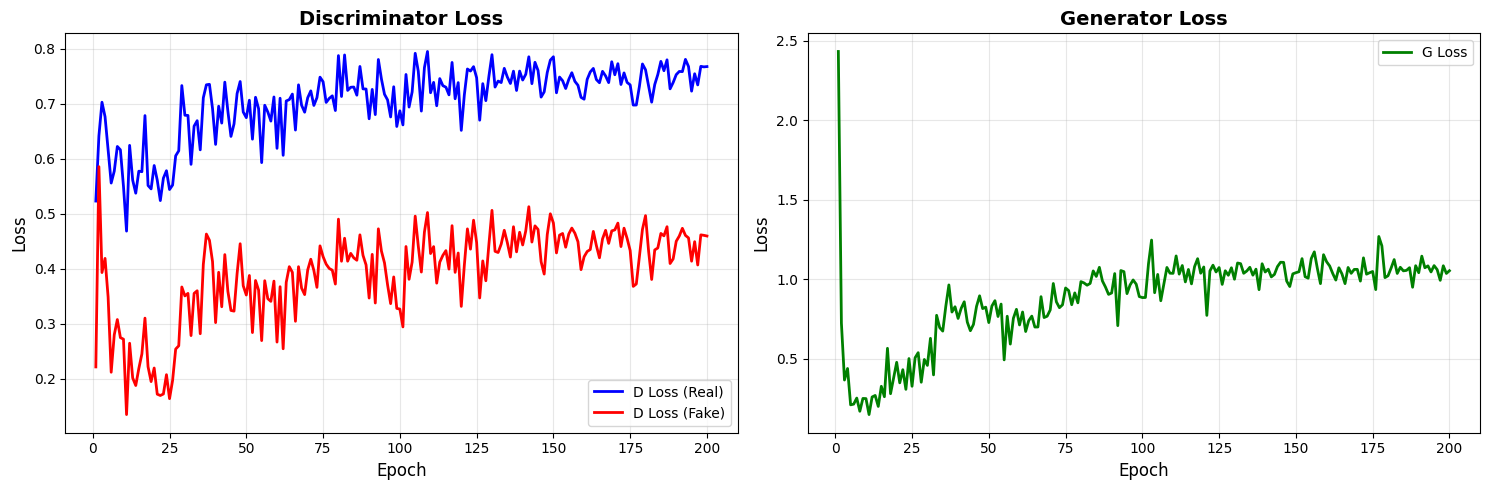

In [12]:
# Plot loss curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot discriminator losses
epochs = range(1, len(history['d_loss_real']) + 1)
axes[0].plot(epochs, history['d_loss_real'], label='D Loss (Real)', color='blue', linewidth=2)
axes[0].plot(epochs, history['d_loss_fake'], label='D Loss (Fake)', color='red', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Discriminator Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot generator loss
axes[1].plot(epochs, history['g_loss'], label='G Loss', color='green', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Generator Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'ex8_models/loss_curves_dim{latent_dim}_bn_epoch{n_epochs}.png', dpi=150, bbox_inches='tight')
print(f"Loss curves saved: ex8_models/loss_curves_dim{latent_dim}_bn_epoch{n_epochs}.png")
plt.show()

1/1 [==============================] - 0s 199ms/step


2025-11-16 01:19:56.569388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


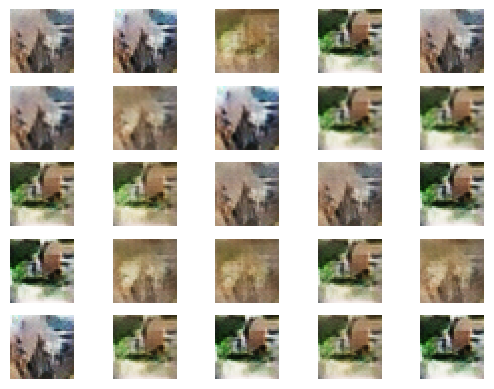

In [13]:
# Now, load the generator model and generate images

# Plot generated images function
def show_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    plt.show()

# Specify which model to load
# Examples (with BatchNorm):
# - "ex8_models/GAN_dim100_bn_epoch010.keras"
# - "ex8_models/GAN_dim100_bn_epoch050.keras"
# - "ex8_models/GAN_dim100_bn_epoch100.keras"
# - "ex8_models/GAN_dim100_bn_epoch200_final.keras"
# 
# Examples (without BatchNorm):
# - "ex8_models/GAN_dim100_epoch200_final.keras"
# - "ex8_models/GAN_dim200_epoch200_final.keras"

model_path = "ex8_models/GAN_dim100_bn_epoch200_final.keras"  # Load BN version
model = load_model(model_path)

# Generate the latent vector (IMPORTANT: use same latent_dim as training!)
latent_points = generate_latent_points(100, 25)  # dim=100 for BN experiment

# Generate images from the latent vector 
X = model.predict(latent_points)

# Scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

# Plot the generated images
# Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
show_plot(X, 5)

Loading ex8_models/GAN_dim100_bn_epoch010.keras...
Loading ex8_models/GAN_dim100_bn_epoch020.keras...


2025-11-16 06:56:45.480627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loading ex8_models/GAN_dim100_bn_epoch030.keras...


2025-11-16 06:56:45.699650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loading ex8_models/GAN_dim100_bn_epoch050.keras...


2025-11-16 06:56:45.905021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-16 06:56:46.100087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loading ex8_models/GAN_dim100_bn_epoch070.keras...
Loading ex8_models/GAN_dim100_bn_epoch100.keras...


2025-11-16 06:56:46.344274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-16 06:56:46.518441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loading ex8_models/GAN_dim100_bn_epoch130.keras...
Loading ex8_models/GAN_dim100_bn_epoch150.keras...


2025-11-16 06:56:46.701013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-16 06:56:46.869482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loading ex8_models/GAN_dim100_bn_epoch180.keras...
Loading ex8_models/GAN_dim100_bn_epoch200_final.keras...


2025-11-16 06:56:47.040420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-16 06:56:47.213883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Saved: ex8_models/generation_comparison_dim100_bn_epochs.png


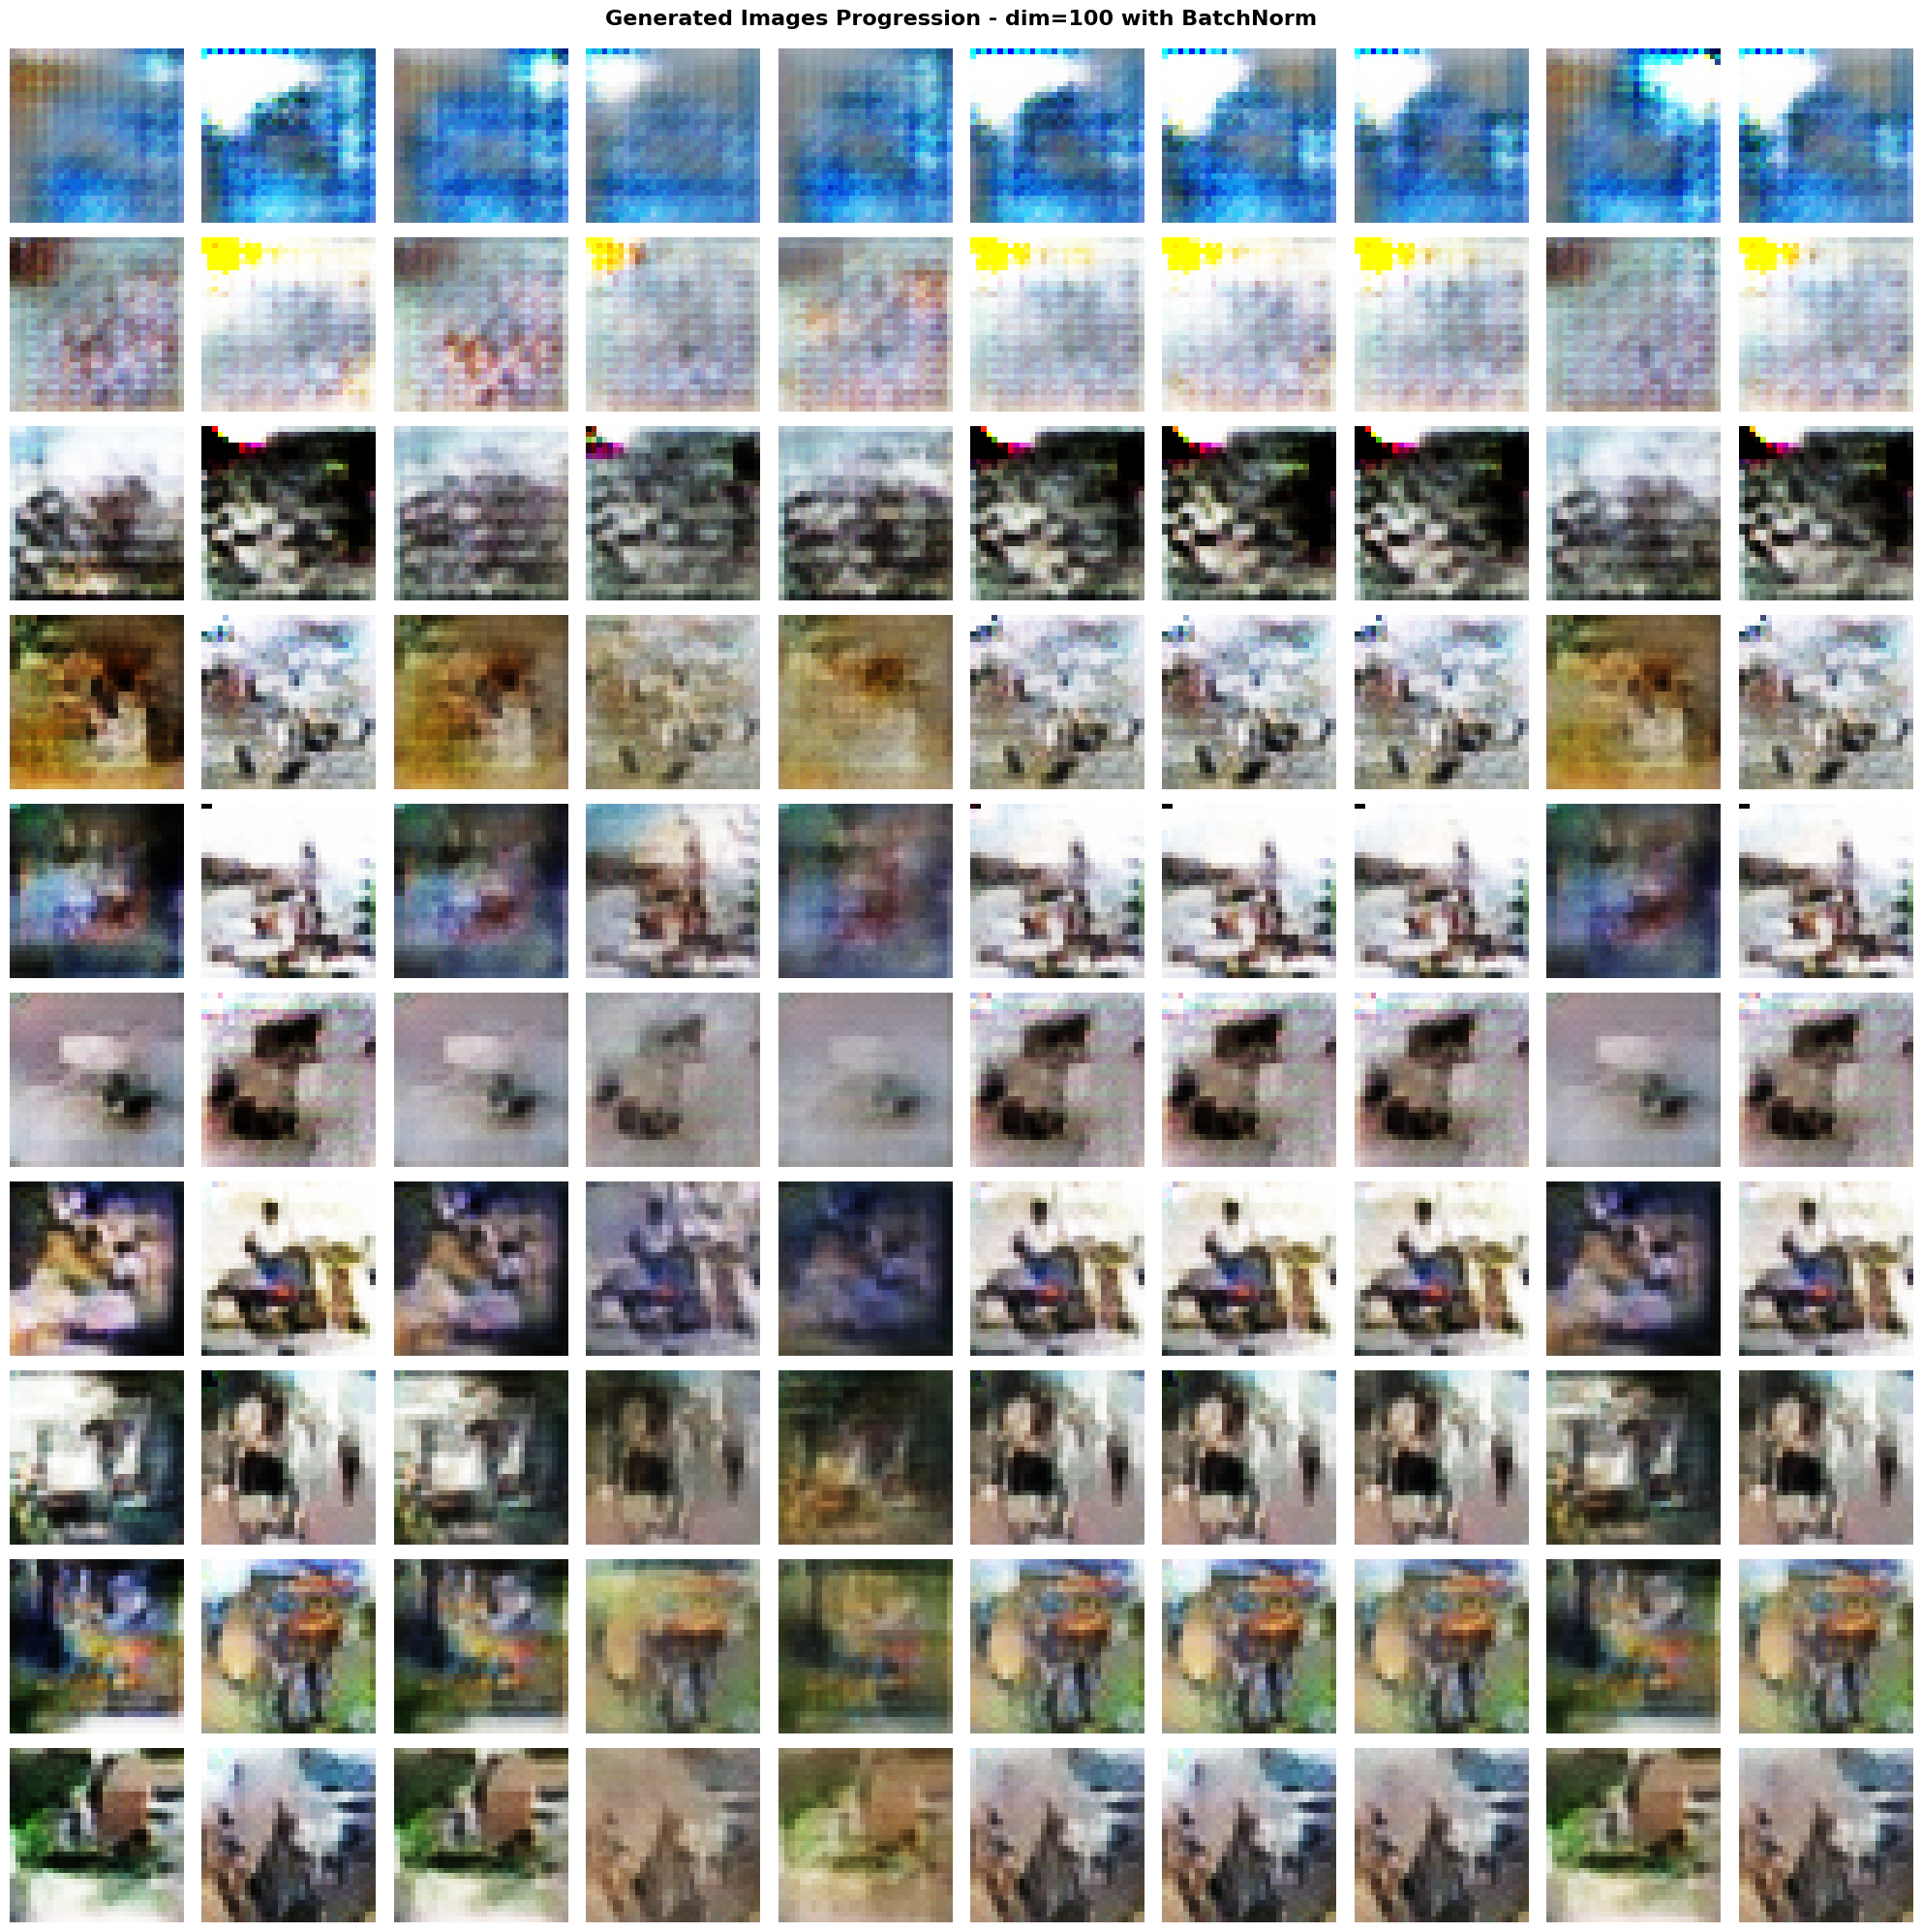

In [15]:
# Compare generated images across different epochs (10-200) with BatchNorm
epochs_to_compare = [10, 20, 30, 50, 70, 100, 130, 150, 180, 200]
n_samples = 10  # Show 10 images per epoch

# Use same latent points for fair comparison
np.random.seed(42)
latent_points = generate_latent_points(100, n_samples)  # Use dim=100 for BN experiment!

fig, axes = plt.subplots(len(epochs_to_compare), n_samples, figsize=(20, 2*len(epochs_to_compare)))

for row, epoch in enumerate(epochs_to_compare):
    # Load model for this epoch (dim=100 with BN)
    if epoch == 200:
        model_path = f"ex8_models/GAN_dim100_bn_epoch{epoch:03d}_final.keras"
    else:
        model_path = f"ex8_models/GAN_dim100_bn_epoch{epoch:03d}.keras"
    
    print(f"Loading {model_path}...")
    model = load_model(model_path)
    
    # Generate images
    X = model.predict(latent_points, verbose=0)
    X = (X + 1) / 2.0
    X = (X * 255).astype(np.uint8)
    
    # Plot images
    for col in range(n_samples):
        axes[row, col].imshow(X[col])
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_ylabel(f'Epoch {epoch}', fontsize=12, fontweight='bold')

plt.suptitle('Generated Images Progression - dim=100 with BatchNorm', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('ex8_models/generation_comparison_dim100_bn_epochs.png', dpi=150, bbox_inches='tight')
print("\nSaved: ex8_models/generation_comparison_dim100_bn_epochs.png")
plt.show()

Loading ex8_models/GAN_dim100_epoch010.keras...
Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.92 GB



2025-11-18 12:15:51.139465: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-18 12:15:51.139860: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2025-11-18 12:15:51.436877: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-11-18 12:15:51.507787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loading ex8_models/GAN_dim200_epoch010.keras...


2025-11-18 12:15:51.888992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loading ex8_models/GAN_dim100_bn_epoch010.keras...
Loading ex8_models/GAN_dim100_epoch050.keras...


2025-11-18 12:15:52.227811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-18 12:15:52.428607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loading ex8_models/GAN_dim200_epoch050.keras...
Loading ex8_models/GAN_dim100_bn_epoch050.keras...


2025-11-18 12:15:52.611512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-18 12:15:52.809171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loading ex8_models/GAN_dim100_epoch100.keras...
Loading ex8_models/GAN_dim200_epoch100.keras...


2025-11-18 12:15:53.045827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-18 12:15:53.206364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loading ex8_models/GAN_dim100_bn_epoch100.keras...
Loading ex8_models/GAN_dim100_epoch150.keras...


2025-11-18 12:15:53.416981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-18 12:15:53.568347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loading ex8_models/GAN_dim200_epoch150.keras...
Loading ex8_models/GAN_dim100_bn_epoch150.keras...


2025-11-18 12:15:53.740998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-18 12:15:53.912559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loading ex8_models/GAN_dim100_epoch200_final.keras...
Loading ex8_models/GAN_dim200_epoch200_final.keras...


2025-11-18 12:15:54.069402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-18 12:15:54.227345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loading ex8_models/GAN_dim100_bn_epoch200_final.keras...


2025-11-18 12:15:54.434017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Saved: ex8_models/generation_comparison_all_models.png


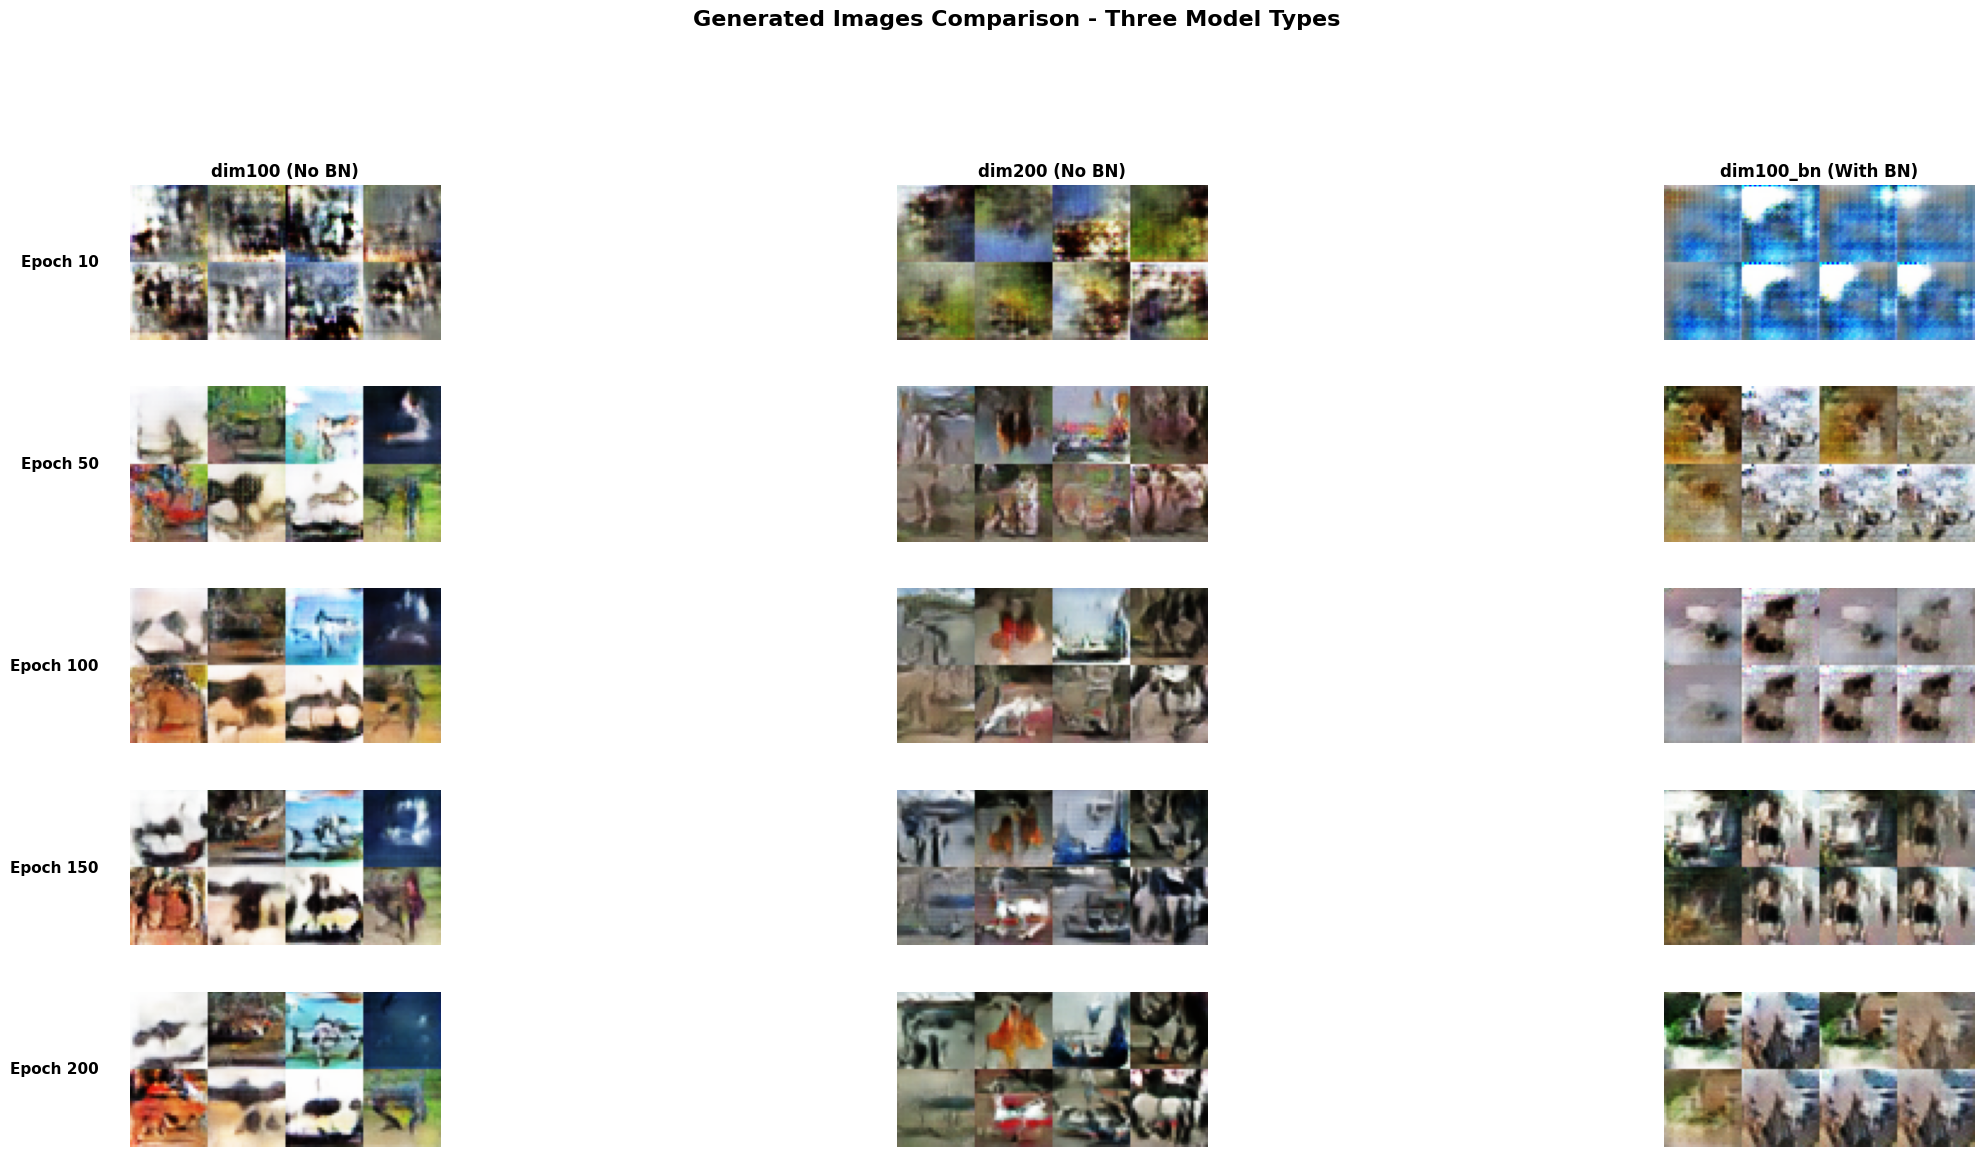

In [4]:
# Compare generated images across three model types at different epochs
# Model types: dim100 (no BN), dim200 (no BN), dim100_bn (with BN)

# Helper function (in case not already defined)
def generate_latent_points(latent_dim, n_samples):
    from numpy.random import randn
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

epochs_to_compare = [10, 50, 100, 150, 200]
n_samples = 8  # Show 8 images per epoch per model

# Model configurations
model_configs = [
    {'name': 'dim100 (No BN)', 'suffix': '', 'latent_dim': 100},
    {'name': 'dim200 (No BN)', 'suffix': '', 'latent_dim': 200},
    {'name': 'dim100_bn (With BN)', 'suffix': '_bn', 'latent_dim': 100}
]

# Create figure: rows = epochs, cols = models * samples
n_models = len(model_configs)
fig = plt.figure(figsize=(n_samples * n_models * 1.2, len(epochs_to_compare) * 2.5))

# Create grid layout
from matplotlib.gridspec import GridSpec
gs = GridSpec(len(epochs_to_compare), n_models, figure=fig, wspace=0.1, hspace=0.3)

for row, epoch in enumerate(epochs_to_compare):
    for model_idx, config in enumerate(model_configs):
        # Set random seed for consistent latent points per model type
        np.random.seed(42)
        latent_points = generate_latent_points(config['latent_dim'], n_samples)
        
        # Load model
        if epoch == 200:
            model_path = f"ex8_models/GAN_dim{config['latent_dim']}{config['suffix']}_epoch{epoch:03d}_final.keras"
        else:
            model_path = f"ex8_models/GAN_dim{config['latent_dim']}{config['suffix']}_epoch{epoch:03d}.keras"
        
        print(f"Loading {model_path}...")
        model = load_model(model_path)
        
        # Generate images
        X = model.predict(latent_points, verbose=0)
        X = (X + 1) / 2.0
        X = (X * 255).astype(np.uint8)
        
        # Create subplot for this model at this epoch
        ax = fig.add_subplot(gs[row, model_idx])
        
        # Create a grid of images for this cell
        grid_img = np.zeros((32 * 2, 32 * 4, 3), dtype=np.uint8)
        for i in range(min(8, n_samples)):
            r, c = i // 4, i % 4
            grid_img[r*32:(r+1)*32, c*32:(c+1)*32] = X[i]
        
        ax.imshow(grid_img)
        ax.axis('off')
        
        # Add labels
        if row == 0:
            ax.set_title(config['name'], fontsize=12, fontweight='bold')
        if model_idx == 0:
            ax.text(-0.1, 0.5, f'Epoch {epoch}', transform=ax.transAxes,
                   fontsize=11, fontweight='bold', va='center', ha='right')

plt.suptitle('Generated Images Comparison - Three Model Types', 
             fontsize=16, fontweight='bold', y=1.02)
plt.savefig('ex8_models/generation_comparison_all_models.png', dpi=150, bbox_inches='tight')
print("\nSaved: ex8_models/generation_comparison_all_models.png")
plt.show()

Loaded ex8_models/loss_history_dim100_epoch200.csv: 200 epochs
Loaded ex8_models/loss_history_dim200_epoch200.csv: 200 epochs
Loaded ex8_models/loss_history_dim100_bn_epoch200.csv: 200 epochs

Saved: ex8_models/loss_curves_comparison_all_models.png


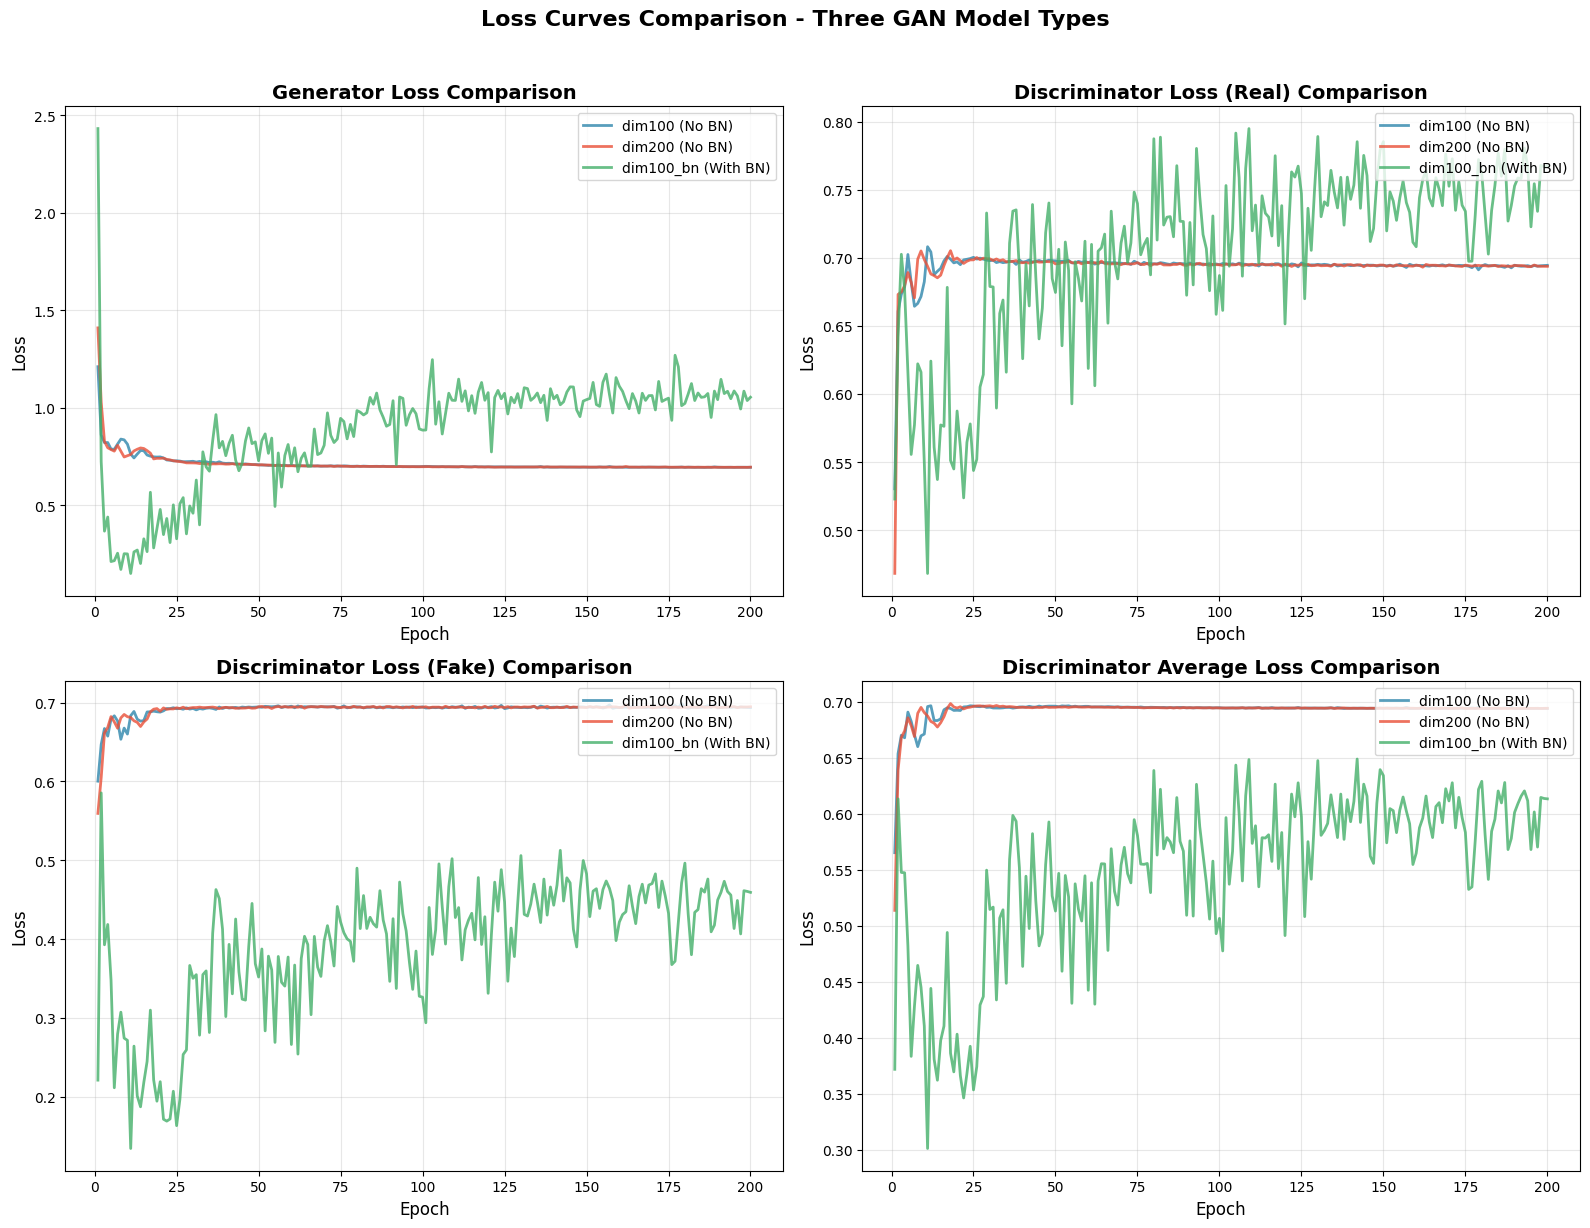


Final Loss Values (Epoch 200)

dim100 (No BN):
  Generator Loss:     0.6949
  D Loss (Real):      0.6945
  D Loss (Fake):      0.6936

dim200 (No BN):
  Generator Loss:     0.6957
  D Loss (Real):      0.6937
  D Loss (Fake):      0.6947

dim100_bn (With BN):
  Generator Loss:     1.0544
  D Loss (Real):      0.7674
  D Loss (Fake):      0.4593


In [5]:
# Compare loss curves across three model types
# Load loss history from CSV files

# Load all three loss histories
loss_files = {
    'dim100 (No BN)': 'ex8_models/loss_history_dim100_epoch200.csv',
    'dim200 (No BN)': 'ex8_models/loss_history_dim200_epoch200.csv',
    'dim100_bn (With BN)': 'ex8_models/loss_history_dim100_bn_epoch200.csv'
}

histories = {}
for name, filepath in loss_files.items():
    histories[name] = pd.read_csv(filepath)
    print(f"Loaded {filepath}: {len(histories[name])} epochs")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Colors for each model
colors = {
    'dim100 (No BN)': '#2E86AB',      # Blue
    'dim200 (No BN)': '#E94F37',       # Red
    'dim100_bn (With BN)': '#44AF69'   # Green
}

# Plot 1: Generator Loss Comparison
ax1 = axes[0, 0]
for name, history in histories.items():
    ax1.plot(history['epoch'], history['g_loss'], 
             label=name, color=colors[name], linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Generator Loss Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)

# Plot 2: Discriminator Loss (Real) Comparison
ax2 = axes[0, 1]
for name, history in histories.items():
    ax2.plot(history['epoch'], history['d_loss_real'], 
             label=name, color=colors[name], linewidth=2, alpha=0.8)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Discriminator Loss (Real) Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3)

# Plot 3: Discriminator Loss (Fake) Comparison
ax3 = axes[1, 0]
for name, history in histories.items():
    ax3.plot(history['epoch'], history['d_loss_fake'], 
             label=name, color=colors[name], linewidth=2, alpha=0.8)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Loss', fontsize=12)
ax3.set_title('Discriminator Loss (Fake) Comparison', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right')
ax3.grid(alpha=0.3)

# Plot 4: Combined D Loss (Real + Fake) Comparison
ax4 = axes[1, 1]
for name, history in histories.items():
    combined_d_loss = (history['d_loss_real'] + history['d_loss_fake']) / 2
    ax4.plot(history['epoch'], combined_d_loss, 
             label=name, color=colors[name], linewidth=2, alpha=0.8)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Loss', fontsize=12)
ax4.set_title('Discriminator Average Loss Comparison', fontsize=14, fontweight='bold')
ax4.legend(loc='upper right')
ax4.grid(alpha=0.3)

plt.suptitle('Loss Curves Comparison - Three GAN Model Types', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('ex8_models/loss_curves_comparison_all_models.png', dpi=150, bbox_inches='tight')
print("\nSaved: ex8_models/loss_curves_comparison_all_models.png")
plt.show()

# Print final loss values for comparison
print("\n" + "="*60)
print("Final Loss Values (Epoch 200)")
print("="*60)
for name, history in histories.items():
    final = history.iloc[-1]
    print(f"\n{name}:")
    print(f"  Generator Loss:     {final['g_loss']:.4f}")
    print(f"  D Loss (Real):      {final['d_loss_real']:.4f}")
    print(f"  D Loss (Fake):      {final['d_loss_fake']:.4f}")

## Experiment Analysis

I modified the training function to record loss history (d_loss_real, d_loss_fake, g_loss) at each epoch and save model checkpoints every 10 epochs. This allows me to analyze training progress and compare different configurations.

### Experiment 1: dim100

Loss Curve:
- G Loss drops from ~1.2 to ~0.75, then stays stable
- D Loss (Real/Fake) stable at ~0.69
- Smooth curves, training is stable

Image Quality:
- Epoch 10: blurry color blocks
- Epoch 50: basic shapes visible
- Epoch 200: stable quality, good diversity

### Experiment 2: dim200

Loss Curve:
- Almost same as dim100
- G Loss stable at ~0.75
- D Loss stable at ~0.69

Image Quality:
- Similar to dim100 at all stages
- Increasing latent dimension shows no clear improvement

### Experiment 3: dim100_bn

To improve image quality, I tried adding Batch Normalization to Generator and adjusted Discriminator settings.

Configuration Changes:
- Added Batch Normalization to Generator
- Discriminator label smoothing (0.9)
- Discriminator learning rate reduced by half

Loss Curve:
- G Loss very high at start (~2.4), drops to ~1.0 after epoch 50
- D Loss (Fake) very low at start (~0.1), meaning D is too strong
- Curves have big oscillations, training is less stable

Image Quality:
- Epoch 10: almost all blue-white blocks (BatchNorm not stable yet)
- Epoch 50: shapes start to appear
- Epoch 200: quality catches up, but less diversity

### Why Images Are Blurry

1. Dataset limitation: CIFAR-10 is only 32x32 pixels, already small and blurry

2. Model limitation: only 2 conv layers, network too shallow to learn details

3. Loss function: Binary Cross-Entropy tends to generate "safe" blurry outputs

4. GAN behavior: Generator tends to generate "average" of multiple images to fool Discriminator